# IS5126 Individual Assignment 1 - HW1

## 1. Header Section

### Assignment Information
- **Assignment Title**: Scientific Discovery Research System
- **Research Domain**: Scientific Discoveries and Breakthroughs
- **Student Name**: Li Jinxuan
  
### Why I Chose This Domain
I selected the **Scientific Discoveries and Breakthroughs** domain for the following reasons:
1. **Historical Significance**: Scientific discoveries represent pivotal moments in human knowledge advancement, making them ideal for comprehensive analysis and comparison.
2. **Cross-Disciplinary Nature**: This domain spans multiple scientific fields (biology, physics, chemistry, computer science), allowing for rich cross-field comparisons and insights.
3. **Rich Data Sources**: Wikipedia contains extensive, well-structured information about major scientific discoveries, providing reliable data for analysis.
4. **Real-World Impact**: These discoveries have transformed society and continue to influence modern technology, making the research highly relevant and meaningful.
5. **Analytical Potential**: The structured nature of scientific discovery data (discoverers, years, mechanisms, applications) enables sophisticated data analysis and visualization.

### Selected Wikipedia Articles
I have selected the following **8 Wikipedia articles** that form a cohesive research set:

***Core Articles (Currently Active):***
- **CRISPR** - Revolutionary gene editing technology
- **Quantum Computing** - Next-generation computing paradigm
- **Gravitational Wave** - Detection of spacetime ripples
- **Higgs Boson** - Fundamental particle discovery
- **mRNA Vaccine** - Modern vaccine technology (COVID-19 breakthrough)
-
***Additional Articles (Available for Analysis):***
- **Ancient DNA** - Paleogenomics and evolutionary biology
- **Water on Mars** - Planetary science discovery
- **Penicillin** - First antibiotic discovery


## 2. Setup and Configuration

In [44]:
%pip install crawl4ai
%pip install beautifulsoup4 lxml requests
!playwright install
print("✅ All libraries installed successfully!")

Playwright Host validation warning: 
╔══════════════════════════════════════════════════════╗
║ Host system is missing dependencies to run browsers. ║
║ Missing libraries:                                   ║
║     libwoff2dec.so.1.0.2                             ║
║     libgstgl-1.0.so.0                                ║
║     libgstcodecparsers-1.0.so.0                      ║
║     libavif.so.13                                    ║
║     libharfbuzz-icu.so.0                             ║
║     libenchant-2.so.2                                ║
║     libsecret-1.so.0                                 ║
║     libhyphen.so.0                                   ║
║     libmanette-0.2.so.0                              ║
╚══════════════════════════════════════════════════════╝
    at validateDependenciesLinux (/usr/local/lib/python3.12/dist-packages/playwright/driver/package/lib/server/registry/dependencies.js:269:9)
    at process.processTicksAndRejections (node:internal/process/task_queues:105

In [45]:
# Import required libraries
import json
import os
from typing import List, Dict, Any, Optional
from openai import OpenAI
from getpass import getpass
import traceback
import asyncio
import nest_asyncio
import time
import re
import csv
import json
from typing import Dict, List, Any
from crawl4ai import AsyncWebCrawler
from bs4 import BeautifulSoup
from pydantic import BaseModel, Field
from typing import List, Optional, Dict, Any
import openai
from openai import OpenAI
import time
import logging
from datetime import datetime
import os
import json
import openai
import os
from typing import List, Dict, Any, Optional
from datetime import datetime
import nest_asyncio, asyncio

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set font for visualization
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Enable nest_asyncio to support async operations in Jupyter
nest_asyncio.apply()


print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [46]:
# Global data storage for memory-based data flow
GLOBAL_STRUCTURED_DATA = None

def set_global_data(data: List[Dict[str, Any]]):
    """Set global structured data for use by all functions"""
    global GLOBAL_STRUCTURED_DATA
    GLOBAL_STRUCTURED_DATA = data
    print(f"✅ Global data set with {len(data)} items")

def get_global_data() -> Optional[List[Dict[str, Any]]]:
    """Get global structured data"""
    return GLOBAL_STRUCTURED_DATA

In [47]:
from pydantic import BaseModel, Field
import openai
from openai import OpenAI
from typing import List, Dict, Any, Optional
import logging

class SearchStrategy(BaseModel):
    """Schema for search strategy suggestion"""
    search_type: str = Field(description="Suggested search type ('name', 'scientist', 'application', 'general')")
    explanation: str = Field(description="Brief explanation of the suggested strategy")
    confidence: float = Field(description="Confidence level of the suggestion (0.0 to 1.0)")

class QueryMatchAnalysis(BaseModel):
    """Schema for query matching analysis"""
    best_match: Optional[str] = Field(description="Best matching item from the available options")
    confidence: float = Field(description="Confidence level of the match (0.0 to 1.0)")
    reasoning: str = Field(description="Reasoning for the best match")
    alternative_matches: List[str] = Field(description="List of alternative matches with lower confidence")

class OpenAIAnalyzer:
    """Helper class for OpenAI-powered analysis and matching"""

    def __init__(self, api_key: Optional[str] = None, model: str = "gpt-4o-mini"):
        """Initialize the analyzer"""
        self.model = model
        self.client = None

        # Use provided key or environment variable
        final_api_key = api_key or os.getenv('OPENAI_API_KEY')

        if final_api_key:
            try:
                self.client = openai.OpenAI(api_key=final_api_key)
                print("✅ OpenAI analyzer client initialized")
            except Exception as e:
                print(f"❌ Error initializing OpenAI client: {e}")
                self.client = None # Ensure client is None if initialization fails
        else:
            print("⚠️ No OpenAI API key provided for analyzer")

        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def analyze_query_match(self, query: str, available_options: List[str]) -> Dict[str, Any]:
        """Analyze query and find best match among available options using OpenAI"""
        if not self.client:
            self.logger.warning("OpenAI client not available for matching analysis")
            return {"best_match": None, "confidence": 0.0, "reasoning": "OpenAI client not initialized", "alternative_matches": []}

        system_prompt = """
        You are a sophisticated matching engine. Given a user query and a list of available options,
        identify the option that best matches the query. Provide a confidence score (0.0 to 1.0)
        and a brief explanation. Also list a few alternative matches if relevant.
        """

        user_prompt = f"""
        User query: "{query}"
        Available options: {available_options}

        Please provide the best match from the 'available_options' for the 'User query'.
        If no strong match exists, indicate this with low confidence.
        """

        try:
            response = self.client.beta.chat.completions.parse(
                model=self.model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                response_format=QueryMatchAnalysis,
                temperature=0.1
            )
            return response.choices[0].message.parsed.dict()

        except Exception as e:
            self.logger.error(f"Error during query match analysis: {e}")
            return {"best_match": None, "confidence": 0.0, "reasoning": f"Error: {e}", "alternative_matches": []}

    def suggest_search_strategy(self, query: str, sample_data: List[Dict[str, Any]]) -> Dict[str, Any]:
        """Suggest the best search strategy for a user query based on sample data"""
        if not self.client:
            self.logger.warning("OpenAI client not available for strategy suggestion")
            return {"search_type": "general", "explanation": "OpenAI client not initialized, using general search", "confidence": 0.0}

        system_prompt = """
        You are a search strategy advisor for a scientific discovery database.
        Analyze the user query and suggest the most appropriate search type:
        - 'name': The user is asking about a specific discovery or technology by its name.
        - 'scientist': The user is asking about a scientist's work or discoveries.
        - 'application': The user is asking about discoveries related to a specific application area or field.
        - 'general': The query is broad or doesn't fit the other categories.

        Provide a brief explanation for your suggestion and a confidence score.
        """

        sample_discovery_names = [d.get('primary_name', '') for d in sample_data if d.get('primary_name')]
        sample_scientist_names = list(set(s for d in sample_data for s in d.get('discoverers', [])))
        sample_applications = list(set(a for d in sample_data for a in d.get('applications', [])))


        user_prompt = f"""
        Analyze the following user query and suggest the best search strategy ('name', 'scientist', 'application', 'general').

        User query: "{query}"

        Consider these example types of data available:
        - Discovery Names: {sample_discovery_names[:5]}
        - Scientist Names: {sample_scientist_names[:5]}
        - Application Areas: {sample_applications[:5]}

        Provide the search type, a brief explanation, and a confidence score.
        """

        try:
            response = self.client.beta.chat.completions.parse(
                model=self.model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                response_format=SearchStrategy,
                temperature=0.1
            )
            return response.choices[0].message.parsed.dict()

        except Exception as e:
            self.logger.error(f"Error during search strategy suggestion: {e}")
            return {"search_type": "general", "explanation": f"Error suggesting strategy: {e}", "confidence": 0.0}

print("✅ OpenAIAnalyzer class definition completed")

✅ OpenAIAnalyzer class definition completed


In [48]:
# determine your researching topic
search_terms = [
        "CRISPR",
        "RNA vaccine",
        "Quantum computing",
        "Ancient DNA",
        "Penicillin",
        "Gravitational wave",
        "Higgs boson",
        "Water on Mars",
        "Cancer immunotherapy",
        "Synthetic biology",
        "Neuroscience",
        "Climate change",
        ]

# determine your queries
example_queries = [
    "Please compare the scientific discoveries of CRISPR and quantum computing.",
    "What are the major research discoveries of Jennifer Doudna?",
    "Search for scientific discoveries applied in the field of medicine.",
    "Give me a detailed introduction to CRISPR technology."
    "What are the key features of the Higgs boson?",
    "How does CRISPR technology work?",
    "What is the impact of climate change on the environment?",
    "What is the role of synthetic biology in medicine?",
    "What is the impact of CRISPR on the field of medicine?",

]

In [49]:
# Global API Key Configuration
# =============================

def setup_global_api_key():
    """
    Setup global OpenAI API key
    """
    global OPENAI_API_KEY

    # First try to read from environment variables
    api_key = os.getenv('OPENAI_API_KEY')

    if api_key:
        print("✅ OpenAI API key found in environment variables")
        OPENAI_API_KEY = api_key
        return api_key

    # If not found in environment variables, prompt for input
    print("�� OpenAI API key not found in environment variables")
    print("Please choose input method:")
    print("1. Secure input (recommended) - input will be hidden")
    print("2. Normal input - input will be visible")

    try:
        choice = input("Please choose input method (1/2): ").strip()

        if choice == "1":
            # Secure input
            api_key = getpass("Please enter OpenAI API key (input will be hidden): ")
        else:
            # Normal input
            api_key = input("Please enter OpenAI API key: ")

        if api_key and api_key.strip():
            OPENAI_API_KEY = api_key.strip()
            print("✅ OpenAI API key set successfully!")

            # Save to environment variable (valid for current session only)
            os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
            print("💡 Note: API key has been saved to environment variables for current session")

            return OPENAI_API_KEY
        else:
            print("❌ API key cannot be empty")
            return None

    except KeyboardInterrupt:
        print("\n❌ User cancelled input")
        return None
    except Exception as e:
        print(f"❌ Error occurred during input: {e}")
        return None

def get_global_api_key():
    """
    Get global API key
    """
    global OPENAI_API_KEY
    return OPENAI_API_KEY

def check_api_key_status():
    """
    Check API key status
    """
    global OPENAI_API_KEY

    if not OPENAI_API_KEY:
        print("❌ OpenAI API key not set")
        return False

    # Simple validation of API key format (should start with 'sk-')
    if not OPENAI_API_KEY.startswith('sk-'):
        print("⚠️ API key format may be incorrect (should start with 'sk-')")
        return False

    print("✅ OpenAI API key is set and format is correct")
    return True

# Initialize global variable
OPENAI_API_KEY = None

# Automatically setup API key
print("🚀 Setting up OpenAI API key...")
setup_global_api_key()

# Check API key status
check_api_key_status()

🚀 Setting up OpenAI API key...
✅ OpenAI API key found in environment variables
✅ OpenAI API key is set and format is correct


True

## 3. Part 1: Wikipedia Scraper Implementation:
– WikipediaScraper class with all required methods
– Demonstration of scraping your chosen 5+ Wikipedia articles
– Explanation of how your articles relate to your research domain
– Error handling examples with sample outputs

How These Articles Relate to My Research Domain

These 12 Wikipedia articles form a cohesive research set for **Scientific Discoveries and Breakthroughs** because they:

***Temporal Coverage:***
- **Historical Foundation**: Penicillin (1928) - the first antibiotic
- **Modern Breakthroughs**: CRISPR (2012), Higgs Boson (2012), Gravitational Waves (2015)
- **Contemporary Innovation**: RNA Vaccines (2020s), Cancer Immunotherapy, Synthetic Biology

***Cross-Disciplinary Representation:***
- **Biology & Medicine**: CRISPR, RNA Vaccine, Penicillin, Cancer Immunotherapy, Synthetic Biology
- **Physics & Astronomy**: Quantum Computing, Gravitational Wave, Higgs Boson, Water on Mars
- **Environmental Science**: Climate Change
- **Neuroscience**: Brain and nervous system research
- **Evolutionary Biology**: Ancient DNA

***Impact Levels:***
- **Fundamental Science**: Higgs Boson, Gravitational Wave, Ancient DNA
- **Applied Technology**: CRISPR, RNA Vaccine, Quantum Computing, Cancer Immunotherapy
- **Environmental**: Climate Change, Water on Mars
- **Medical**: Penicillin, Cancer Immunotherapy, RNA Vaccine

***Research Methodology:***
- All discoveries involve **collaborative research** across institutions
- Clear **discoverers and research teams** for each breakthrough
- **Peer-reviewed publications** and scientific validation
- **Timeline progression** from discovery to application
- **Real-world applications** and societal impact

***Data Richness:***
Each article contains structured information about:
- **Discoverers and research teams**
- **Discovery years and timelines**
- **Mechanisms and working principles**
- **Applications and real-world impact**
- **Institutions and research centers**
- **Awards and recognition**
- **Significance and future implications**

This selection enables comprehensive analysis of:
- **Scientific discovery patterns** across different eras
- **Cross-field comparisons** and interdisciplinary connections
- **Evolution of research methodologies** over time
- **Impact assessment** of different types of discoveries
- **Collaboration patterns** in scientific research
- **Timeline analysis** of breakthrough development

In [50]:
class WikipediaScraper:
    def __init__(self, base_urls: List[str]):
        """
        Initialize Wikipedia scraper

        Args:
            base_urls: List of Wikipedia article URLs to scrape
        """
        self.base_urls = base_urls
        self.scraped_data = []
        self.rate_limit_delay = 2  # Request interval (seconds) to avoid overloading Wikipedia servers

        # Validate URL format
        self._validate_urls()

    def _validate_urls(self):
        """Validate if URLs are valid Wikipedia links"""
        valid_urls = []
        for url in self.base_urls:
            if self._is_valid_wikipedia_url(url):
                valid_urls.append(url)
            else:
                print(f"Warning: Skipping invalid Wikipedia URL: {url}")

        if not valid_urls:
            raise ValueError("No valid Wikipedia URLs provided")

        self.base_urls = valid_urls
        print(f"Validation passed, {len(valid_urls)} valid URLs found")

    def _is_valid_wikipedia_url(self, url: str) -> bool:
        """Check if URL is a valid Wikipedia URL"""
        try:
            return (
                'wikipedia.org' in url and
                '/wiki/' in url
            )
        except:
            return False

    def _looks_like_html(self, content: str) -> bool:
        """Determine whether a string looks like HTML"""
        try:
            return bool(content and content.lstrip().startswith("<"))
        except Exception:
            return False

    def _html_to_text(self, html: str) -> str:
        """Convert Wikipedia HTML to cleaner plain text (keep title and paragraphs)"""
        try:
            soup = BeautifulSoup(html, "lxml")

            # Title
            title_node = soup.select_one("#firstHeading")
            title_text = title_node.get_text(" ", strip=True) if title_node else ""

            # Main content container
            content = soup.select_one("#mw-content-text") or soup

            # Noise selectors to remove
            noise_selectors = [
                "#toc", ".mw-references-wrap", "table.infobox",
                "div.navbox", "table.metadata", "div.hatnote",
                "script", "style", "noscript",
            ]
            for sel in noise_selectors:
                for node in content.select(sel):
                    node.decompose()

            # Paragraph text
            paragraphs = []
            for p in content.select("p"):
                text = p.get_text(" ", strip=True)
                text = re.sub(r"\s*\[\d+\]", "", text)  # remove footnote like [1]
                if text:
                    paragraphs.append(text)

            combined = ((title_text + "\n\n") if title_text else "") + "\n\n".join(paragraphs)
            combined = re.sub(r"\n{3,}", "\n\n", combined).strip()
            return combined
        except Exception:
            return html

    async def scrape_article(self, url: str) -> Dict[str, Any]:
        """
        Scrape a single Wikipedia article

        Args:
            url: Article URL

        Returns:
            Dictionary containing article information
        """
        try:
            print(f"Starting to scrape article: {url}")

            async with AsyncWebCrawler(verbose=False) as crawler:
                # Scrape article content
                result = await crawler.arun(url)

                if result.success:
                    # Extract article information
                    article_data = self._extract_article_info(result, url)
                    print(f"Successfully scraped article: {article_data.get('title', 'Unknown')}")
                    return article_data
                else:
                    error_msg = result.error_message if hasattr(result, 'error_message') else 'Unknown error'
                    print(f"Scraping failed: {error_msg}")
                    return self._create_error_response(url, error_msg)

        except Exception as e:
            print(f"Error occurred while scraping article {url}: {str(e)}")
            return self._create_error_response(url, str(e))

    def _extract_article_info(self, result, url: str) -> Dict[str, Any]:
        """Extract article info from scraping result"""
        try:
            content = result.html

            # Extract title
            title = self._extract_title(content, url)

            # Extract main content
            main_content = self._extract_main_content(content)

            # Extract key sections
            sections = self._extract_sections(content)

            # Clean content
            cleaned_content = self.clean_content(main_content)

            return {
                'url': url,
                'title': title,
                'main_content': cleaned_content,
                'sections': sections,
                'raw_content_length': len(content),
                'cleaned_content_length': len(cleaned_content),
                'scraped_at': time.strftime('%Y-%m-%d %H:%M:%S'),
                'status': 'success'
            }

        except Exception as e:
            print(f"Error extracting article info: {str(e)}")
            return self._create_error_response(url, f"Extraction failed: {str(e)}")

    def _extract_title(self, content: str, url: str) -> str:
        """Extract article title from HTML content"""
        try:
            soup = BeautifulSoup(content, 'html.parser')

            # Prefer title from h1
            h1_title = soup.find('h1')
            if h1_title:
                title_text = h1_title.get_text(strip=True)
                if title_text and len(title_text) > 0:
                    return title_text

            # Fallback: page <title>
            title_tag = soup.find('title')
            if title_tag:
                title_text = title_tag.get_text(strip=True)
                # Remove suffix like " - Wikipedia"
                if ' - Wikipedia' in title_text:
                    title_text = title_text.split(' - Wikipedia')[0]
                if title_text and len(title_text) > 0:
                    return title_text

            return "Unknown Title"

        except Exception as e:
            print(f"Error extracting title: {str(e)}")
            return "Unknown Title"

    def _extract_main_content(self, content: str) -> str:
        """Extract main article content from HTML"""
        try:
            soup = BeautifulSoup(content, 'html.parser')

            # Locate main content area
            main_content = soup.select_one('#mw-content-text')
            if not main_content:
                main_content = soup

            # Remove noisy elements
            noise_selectors = [
                '#toc', '.mw-references-wrap', 'table.infobox',
                'div.navbox', 'table.metadata', 'div.hatnote',
                'script', 'style', 'noscript', 'table', 'nav',
                '.mw-editsection', '.mw-cite-backlink', '.thumb',
                '.image', 'sup.reference', 'span.mw-ref'
            ]

            for selector in noise_selectors:
                for element in main_content.select(selector):
                    element.decompose()

            # Collect all paragraph text
            paragraphs = main_content.find_all('p')
            content_list = []

            for p in paragraphs:
                text = p.get_text(strip=True)
                if text and len(text) > 10:  # filter out very short paragraphs
                    # remove footnote numbers and artifacts
                    text = re.sub(r'\s*\[\d+\]', '', text)
                    text = re.sub(r'\[\s*\]', '', text)
                    content_list.append(text)

            if content_list:
                return '\n\n'.join(content_list)
            else:
                return "Unable to extract valid content"

        except Exception as e:
            print(f"Failed to extract content from HTML: {str(e)}")
            return content[:1000]  # return first 1000 chars as fallback

    def _extract_sections(self, content: str) -> List[Dict[str, str]]:
        """Extract heading structure from HTML (without content)"""
        try:
            soup = BeautifulSoup(content, 'html.parser')

            # Locate main content area
            main_content = soup.select_one('#mw-content-text')
            if not main_content:
                main_content = soup

            sections = []

            # Find all heading tags
            headings = main_content.find_all(['h1', 'h2', 'h3'])

            for heading in headings:
                level = int(heading.name[1])  # h1->1, h2->2, h3->3
                heading_text = heading.get_text(strip=True)

                # Skip some headings
                if self._should_skip_heading(heading_text):
                    continue

                sections.append({
                    'level': level,
                    'heading': heading_text
                })

            return sections

        except Exception as e:
            print(f"Failed to extract sections from HTML: {str(e)}")
            return []

    def _should_skip_heading(self, heading_text: str) -> bool:
        """Decide whether a heading should be skipped"""
        skip_patterns = [
            'Contents', 'References', 'External links', 'Further reading',
            'See also', 'Notes', 'Bibliography', 'Sources', 'Citations', 'Footnotes'
        ]

        for pattern in skip_patterns:
            if pattern.lower() in heading_text.lower():
                return True
        return False

    def clean_content(self, raw_content: str) -> str:
        """Clean and pre-process scraped content"""
        if not raw_content:
            return ""

        try:
            # Remove excessive whitespace and newlines
            cleaned = re.sub(r'\n{3,}', '\n\n', raw_content)
            cleaned = re.sub(r'[ \t]+', ' ', cleaned)

            # Remove footnote references
            cleaned = re.sub(r'\s*\[\d+\]', '', cleaned)

            # Ensure proper blank lines between paragraphs
            cleaned = re.sub(r'\n{3,}', '\n\n', cleaned)

            return cleaned.strip()

        except Exception as e:
            print(f"Failed to clean content: {e}")
            return raw_content

    async def scrape_all_articles(self, urls: List[str]) -> List[Dict[str, Any]]:
        """Scrape all articles"""
        print(f"Starting batch scrape for {len(urls)} articles")

        all_results = []

        for i, url in enumerate(urls):
            try:
                print(f"Progress: {i+1}/{len(urls)}")

                # Scrape single article
                article_data = await self.scrape_article(url)
                all_results.append(article_data)

                # Rate limit: add delay between requests
                if i < len(urls) - 1:  # not the last one
                    print(f"Waiting {self.rate_limit_delay} seconds...")
                    await asyncio.sleep(self.rate_limit_delay)

            except Exception as e:
                print(f"Error while scraping article {url}: {str(e)}")
                all_results.append(self._create_error_response(url, str(e)))

        self.scraped_data = all_results
        print(f"Batch scrape completed, successfully scraped {len([r for r in all_results if r.get('status') == 'success'])} articles")

        return all_results

    def _create_error_response(self, url: str, error_message: str) -> Dict[str, Any]:
        """Create an error response"""
        return {
            'url': url,
            'title': 'Error',
            'main_content': '',
            'sections': [],
            'error': error_message,
            'status': 'error',
            'scraped_at': time.strftime('%Y-%m-%d %H:%M:%S')
        }

    def save_to_json(self, data: List[Dict[str, Any]], filename: str):
        """Save scraped data to a JSON file"""
        try:
            with open(filename, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=2)
            print(f"Full data saved to: {filename}")
        except Exception as e:
            print(f"Error saving JSON file: {str(e)}")

    def save_content_to_markdown(self, data: List[Dict[str, Any]], filename: str):
        """Save main contents of the results to a Markdown file"""
        try:
            lines = []
            for i, item in enumerate(data, start=1):
                title = item.get('title', f'Article {i}')
                url = item.get('url', '')
                main = item.get('main_content', '').strip()

                lines.append(f"# {title}")
                if url:
                    lines.append(f"Source: {url}")
                lines.append("")

                if main:
                    lines.append(main)
                    lines.append("")

                lines.append("---\n")

            output = "\n".join(lines).strip() + "\n"
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(output)
            print(f"Main content saved to: {filename}")
        except Exception as e:
            print(f"Error saving main content Markdown file: {str(e)}")

    def save_sections_to_markdown(self, data: List[Dict[str, Any]], filename: str):
        """Save section information of the results to a Markdown file"""
        try:
            lines = []
            for i, item in enumerate(data, start=1):
                title = item.get('title', f'Article {i}')
                url = item.get('url', '')
                sections = item.get('sections', [])

                lines.append(f"# {title}")
                if url:
                    lines.append(f"Source: {url}")
                lines.append("")

                if isinstance(sections, list) and sections:
                    for s in sections:
                        if isinstance(s, dict):
                            heading = s.get('heading') or s.get('title') or 'Section'
                            content = s.get('content') or s.get('text') or ''
                            lines.append(f"## {heading}")
                            if content:
                                lines.append(content)
                            lines.append("")
                        else:
                            lines.append(str(s))
                            lines.append("")
                else:
                    lines.append("No sections available")
                    lines.append("")

                lines.append("---\n")

            output = "\n".join(lines).strip() + "\n"
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(output)
            print(f"Section information saved to: {filename}")
        except Exception as e:
            print(f"Error saving section information Markdown file: {str(e)}")

    def get_summary(self) -> Dict[str, Any]:
        """Get scraping summary"""
        if not self.scraped_data:
            return {"message": "No scraped data"}

        successful = [r for r in self.scraped_data if r.get('status') == 'success']
        failed = [r for r in self.scraped_data if r.get('status') == 'error']

        total_content_length = sum(r.get('cleaned_content_length', 0) for r in successful)

        return {
            'total_articles': len(self.scraped_data),
            'successful_scrapes': len(successful),
            'failed_scrapes': len(failed),
            'total_content_length': total_content_length,
            'average_content_length': total_content_length // len(successful) if successful else 0,
            'success_rate': len(successful) / len(self.scraped_data) * 100
        }

print("✅ WikipediaScraper class definition completed")


✅ WikipediaScraper class definition completed


In [51]:
# Utility function to convert search keywords to Wikipedia URLs
def build_wikipedia_urls(terms):
    """Generate Wikipedia article URL list from keywords (English articles).
    - Rules: Replace spaces with underscores; trim whitespace; deduplicate.
    - Note: If keywords are not English or non-standard titles, additional processing/search may be needed.
    """
    if not terms:
        return []
    base = "https://en.wikipedia.org/wiki/"
    urls = []
    seen = set()
    for t in terms:
        if not isinstance(t, str):
            continue
        title = t.strip().replace(" ", "_")
        if not title:
            continue
        url = base + title
        if url not in seen:
            urls.append(url)
            seen.add(url)
    return urls


In [52]:
async def scrape_scientific_discoveries(search_terms_list: Optional[List[str]] = None, save_files: bool = False):
    """Scrape scientific discovery related Wikipedia articles"""
    print("🚀 Starting to scrape scientific discovery related Wikipedia articles...")
    print("=" * 60)
    if search_terms_list != None:
        scientific_urls = build_wikipedia_urls(search_terms_list)
        print(f"✅ Generated {len(scientific_urls)} Wikipedia URLs")
    else:
        search_terms = [
        "CRISPR",
        "RNA vaccine",
        "Gravitational wave",
        "Higgs boson",
        "Quantum computing",
        "Ancient DNA",
        "Water on Mars",
        "Penicillin"
        ]
        scientific_urls = build_wikipedia_urls(search_terms)

    print(scientific_urls)
    scraper = WikipediaScraper(scientific_urls)
    results = await scraper.scrape_all_articles(scientific_urls)

    # Save data only if requested

    scraper.save_to_json(results,"./scientific_discoveries.json")
    scraper.save_content_to_markdown(results,"./content.md")
    scraper.save_sections_to_markdown(results,"./section.md")
    print("💾 Data saved to files")


    # Display summary
    summary = scraper.get_summary()
    print("\n📊 Scraping Results Summary:")
    print("=" * 40)
    for key, value in summary.items():
        print(f"{key}: {value}")

    print(f"\n🎉 Scraping completed! Retrieved data for {len(results)} articles")
    return results

print("✅ Data scraping function definition completed")


✅ Data scraping function definition completed


## Part2 Structured Data Extraction

In [53]:
# Pydantic model designed for scientific discovery domain
class ScientificDiscoveryExtraction(BaseModel):
    """Structured data model for scientific discovery information"""

    # Basic information
    primary_name: str = Field(description="Primary name of the scientific discovery or technology")

    # Discoverers and time
    discoverers: List[str] = Field(description="List of names of main discoverers or researchers")
    discovery_years: List[str] = Field(description="Most important discovery year, strongly recommend returning only one year. Must select the single year that best represents the core breakthrough of the technology/discovery from the article. Priority: key technical implementation > important paper publication > initial concept proposal. For example, for CRISPR, choose 2012 (Doudna and Charpentier's key paper) rather than 1987 (first sequence discovery). Avoid returning multiple years.")
    discovery_timeline: List[str] = Field(description="Timeline from initial to final discovery")

    # Technical details
    mechanism: str = Field(description="Basic working principle or mechanism of the technology")
    key_features: List[str] = Field(description="Main features or advantages of the technology")

    # Applications and impact
    applications: List[str] = Field(description="Main application fields or uses")
    significance: str = Field(description="Scientific or social significance of the discovery")

    # Optional additional information
    institutions: Optional[List[str]] = Field(default=None, description="Related research institutions or universities")
    awards: Optional[List[str]] = Field(default=None, description="Important awards or honors received")

    # Metadata
    extracted_at: str = Field(default_factory=lambda: datetime.now().isoformat(), description="Data extraction time")

print("✅ Scientific discovery domain Pydantic model definition completed")


✅ Scientific discovery domain Pydantic model definition completed


In [54]:
class StructuredDataExtractor:
    """A class for structured data extraction using the OpenAI API"""

    def __init__(self, api_key: str = None, model: str = "gpt-4o-mini"):
        """
        Initialize the extractor

        Args:
            api_key: OpenAI API key (optional, will use environment variable OPENAI_API_KEY first)
            model: Model name to use
        """

        self.model = model
        self.client = None

        # Prefer the provided API key, then the environment variable; if not found, ask interactively
        final_api_key = os.getenv('OPENAI_API_KEY')
        if not final_api_key:
            try:
                final_api_key = getpass('Please enter OPENAI_API_KEY (input will be hidden): ')
            except Exception:
                final_api_key = input('Please enter OPENAI_API_KEY: ')

        if final_api_key:
            self.client = openai.OpenAI(api_key=final_api_key)
            print("✅ OpenAI client initialized successfully")
        else:
            print("⚠️ No OpenAI API key found, related features will be limited")

        # Set up logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

        # Retry configuration
        self.max_retries = 3
        self.retry_delay = 2  # seconds

    def extract_structured_data(self, content: str, model: str = None) -> Optional[ScientificDiscoveryExtraction]:
        """
        Extract structured data using OpenAI structured output

        Args:
            content: Text content to extract
            model: Model to use (optional)

        Returns:
            ScientificDiscoveryExtraction: Extracted structured data
        """
        if not self.client:
            self.logger.error("OpenAI client not initialized, please provide an API key")
            return None

        model_to_use = model or self.model

        # Build system prompt
        system_prompt = """
        You are a professional scientific literature analyst. Please extract structured information
        from the given scientific article content.

        Extract the following information:
        1. Main name of the scientific discovery or technology
        2. Main discoverer(s) or researcher(s)
        3. Important discovery time points
        4. Timeline of the discovery
        5. Basic working principle of the technology
        6. Main features and advantages
        7. Application areas
        8. Scientific significance
        9. Related institutions (if any)
        10. Awards received (if any)

        **Important extraction rules**:
        - For discovery_years, follow these rules:
          * If a range of years is mentioned (e.g., "2010-2012", "from 2008 to 2011"),
            determine which year is most relevant to the key discovery in the title
          * Prefer the year associated with the key breakthrough, first publication, or major experiment success
          * If multiple years are mentioned and it's unclear which is more important, return the earliest one
          * Example: If the title is "CRISPR gene-editing technology" and the text says
            "Research started in 2008, breakthrough in 2012", choose 2012
          * If completely uncertain, return the earliest year in the range

        If some information is not explicitly mentioned, try to infer from the context,
        or state "unclear" in the corresponding field.
        """

        user_prompt = f"""
        Please extract structured information from the following scientific article content:

        {content}  # Limit length to avoid token issues

        Please extract information according to the ScientificDiscoveryExtraction model.

        **Special note on discovery_years**:
        - Carefully read the article title and content to understand the core of the scientific discovery
        - If a year range is present, decide which year best represents the key breakthrough
        - Priority: first major publication, critical technical success, or key experimental result
        - If unclear, choose the earliest year in the range
        """

        # Try extraction with retries
        for attempt in range(self.max_retries):
            try:
                self.logger.info(f"Starting extraction attempt {attempt + 1}...")

                response = self.client.beta.chat.completions.parse(
                    model=model_to_use,
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": user_prompt}
                    ],
                    response_format=ScientificDiscoveryExtraction,
                    temperature=0.1  # Low temperature for consistency
                )

                # Extract structured data
                extracted_data = response.choices[0].message.parsed

                if extracted_data:
                    self.logger.info("✅ Structured data extraction succeeded")
                    return extracted_data
                else:
                    self.logger.warning("⚠️ API returned empty data")

            except openai.RateLimitError as e:
                self.logger.warning(f"Rate limit error (attempt {attempt + 1}/{self.max_retries}): {e}")
                if attempt < self.max_retries - 1:
                    time.sleep(self.retry_delay * (2 ** attempt))  # exponential backoff

            except openai.APIError as e:
                self.logger.error(f"OpenAI API error (attempt {attempt + 1}/{self.max_retries}): {e}")
                if attempt < self.max_retries - 1:
                    time.sleep(self.retry_delay)

            except Exception as e:
                self.logger.error(f"Unknown error (attempt {attempt + 1}/{self.max_retries}): {e}")
                if attempt < self.max_retries - 1:
                    time.sleep(self.retry_delay)

        self.logger.error("❌ All extraction attempts failed")
        return None

    def batch_extract(self, articles: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """
        Process multiple articles in batch

        Args:
            articles: List of article data

        Returns:
            List[Dict]: List of extraction results
        """
        results = []

        self.logger.info(f"Starting batch processing of {len(articles)} articles...")

        for i, article in enumerate(articles):
            try:
                self.logger.info(f"Processing article {i+1}/{len(articles)}: {article.get('title', 'Unknown')}")

                # Check article status
                if article.get('status') != 'success':
                    self.logger.warning(f"Skipping failed article: {article.get('error', 'Unknown error')}")
                    results.append({
                        'article_info': article,
                        'extraction_status': 'skipped',
                        'extraction_error': article.get('error', 'Article scraping failed'),
                        'structured_data': None
                    })
                    continue

                # Extract main content
                content = article.get('main_content', '')
                if not content:
                    self.logger.warning("Article content is empty, skipping")
                    results.append({
                        'article_info': article,
                        'extraction_status': 'failed',
                        'extraction_error': 'Empty content',
                        'structured_data': None
                    })
                    continue

                # Run structured extraction
                extracted_data = self.extract_structured_data(content)

                if extracted_data:
                    results.append({
                        'article_info': article,
                        'extraction_status': 'success',
                        'extraction_error': None,
                        'structured_data': extracted_data.dict()
                    })
                else:
                    results.append({
                        'article_info': article,
                        'extraction_status': 'failed',
                        'extraction_error': 'Extraction failed after retries',
                        'structured_data': None
                    })

                # Delay to avoid rate limit
                if i < len(articles) - 1:
                    time.sleep(1)

            except Exception as e:
                self.logger.error(f"Error processing article: {e}")
                results.append({
                    'article_info': article,
                    'extraction_status': 'error',
                    'extraction_error': str(e),
                    'structured_data': None
                })

        # Summary statistics
        successful = len([r for r in results if r['extraction_status'] == 'success'])
        failed = len([r for r in results if r['extraction_status'] in ['failed', 'error']])
        skipped = len([r for r in results if r['extraction_status'] == 'skipped'])

        self.logger.info(f"Batch processing finished: Success {successful}, Failed {failed}, Skipped {skipped}")

        return results

    def save_extraction_results(self, results: List[Dict[str, Any]], filename: str):
        """
        Save extraction results to a file

        Args:
            results: List of extraction results
            filename: Output file name
        """
        try:
            with open(filename, 'w', encoding='utf-8') as f:
                json.dump(results, f, ensure_ascii=False, indent=2, default=str)
            self.logger.info(f"✅ Extraction results saved to: {filename}")
        except Exception as e:
            self.logger.error(f"❌ Error saving file: {e}")

print("✅ Structured data extractor class definition completed")


✅ Structured data extractor class definition completed


In [55]:
def perform_structured_extraction(scraper_result):
    """Perform structured data extraction and return results directly (no file saving)"""
    print("🚀 Starting structured data extraction...")
    print("=" * 60)

    # Check API key
    final_api_key = os.getenv('OPENAI_API_KEY')
    if not final_api_key:
        try:
            final_api_key = getpass('Please enter OPENAI_API_KEY (input will be hidden): ')
        except Exception:
            final_api_key = input('Please enter OPENAI_API_KEY: ')

    if not final_api_key:
        print("❌ No API key provided, cannot perform extraction")
        return None

    try:
        # 1. Initialize the extractor
        extractor = StructuredDataExtractor()

        if scraper_result is not None:
            scraped_articles = scraper_result
            print(f" Using the provided scraping results")
        else:
            print(f"❌ No scraping results provided")
            return None

        print(f"📖 Successfully loaded {len(scraped_articles)} articles")

        # 2. Perform batch structured extraction
        print("🔄 Starting batch structured extraction...")
        extraction_results = extractor.batch_extract(scraped_articles)

        # 3. Show extraction statistics
        successful = [r for r in extraction_results if r['extraction_status'] == 'success']
        failed = [r for r in extraction_results if r['extraction_status'] != 'success']

        print(f"\n📊 Extraction statistics:")
        print(f"✅ Successfully extracted: {len(successful)} articles")
        print(f"❌ Failed to extract: {len(failed)} articles")

        # 4. Display the first successful extraction result
        if successful:
            first_result = successful[0]
            print(f"\n📄 Sample extraction result - {first_result['article_info']['title']}:")
            print("-" * 50)
            structured = first_result['structured_data']
            print(f"📝 Primary name: {structured['primary_name']}")
            print(f"👥 Discoverers: {', '.join(structured['discoverers'])}")
            print(f" Discovery years: {', '.join(structured['discovery_years'])}")
            print(f" Applications: {len(structured['applications'])} items")
            print(f"⭐ Key features: {len(structured['key_features'])} items")

        # 5. 存储extraction_results到JSON文件
        print(f"\n Storing extraction results to JSON file...")
        try:
            # 直接使用extraction_results作为文件名
            json_filename = "extraction_results.json"

            # 保存到JSON文件
            with open(json_filename, 'w', encoding='utf-8') as f:
                json.dump(extraction_results, f, ensure_ascii=False, indent=2, default=str)

            print(f"✅ Extraction results saved to: {json_filename}")

        except Exception as e:
            print(f"⚠️ Warning: Error saving data to JSON file: {str(e)}")
            print("   Data will still be returned in memory")

        print(f"\n✅ Structured extraction completed! Results returned directly and saved to JSON file")

        return extraction_results

    except Exception as e:
        print(f"❌ Execution error: {str(e)}")
        print("Please check the API key settings")
        return None

## Part 3: Function Calling Implementation

In [56]:
def perform_structured_extraction(scraper_result):
    """Perform structured data extraction and return results directly (no file saving)"""
    print("🚀 Starting structured data extraction...")
    print("=" * 60)

    # Check API key
    final_api_key = os.getenv('OPENAI_API_KEY')
    if not final_api_key:
        try:
            final_api_key = getpass('Please enter OPENAI_API_KEY (input will be hidden): ')
        except Exception:
            final_api_key = input('Please enter OPENAI_API_KEY: ')

    if not final_api_key:
        print("❌ No API key provided, cannot perform extraction")
        return None

    try:
        # 1. Initialize the extractor
        extractor = StructuredDataExtractor()

        if scraper_result is not None:
            scraped_articles = scraper_result
            print(f"�� Using the provided scraping results")
        else:
            print(f"❌ No scraping results provided")
            return None

        print(f"📖 Successfully loaded {len(scraped_articles)} articles")

        # 2. Perform batch structured extraction
        print("🔄 Starting batch structured extraction...")
        extraction_results = extractor.batch_extract(scraped_articles)

        # 3. Show extraction statistics
        successful = [r for r in extraction_results if r['extraction_status'] == 'success']
        failed = [r for r in extraction_results if r['extraction_status'] != 'success']

        print(f"\n📊 Extraction statistics:")
        print(f"✅ Successfully extracted: {len(successful)} articles")
        print(f"❌ Failed to extract: {len(failed)} articles")

        # 4. Display the first successful extraction result
        if successful:
            first_result = successful[0]
            print(f"\n📄 Sample extraction result - {first_result['article_info']['title']}:")
            print("-" * 50)
            structured = first_result['structured_data']
            print(f"📝 Primary name: {structured['primary_name']}")
            print(f"👥 Discoverers: {', '.join(structured['discoverers'])}")
            print(f"�� Discovery years: {', '.join(structured['discovery_years'])}")
            print(f"�� Applications: {len(structured['applications'])} items")
            print(f"⭐ Key features: {len(structured['key_features'])} items")

        # 5. 在返回数据之前存储为JSON文件
        print(f"\n�� Storing extraction results to JSON file...")
        try:
            # 生成带时间戳的文件名
            timestamp = time.strftime("%Y%m%d_%H%M%S")
            json_filename = f"structured_extractions_{timestamp}.json"

            # 保存到JSON文件
            with open(json_filename, 'w', encoding='utf-8') as f:
                json.dump(extraction_results, f, ensure_ascii=False, indent=2, default=str)

            print(f"✅ Extraction results saved to: {json_filename}")

        except Exception as e:
            print(f"⚠️ Warning: Error saving data to JSON file: {str(e)}")
            print("   Data will still be returned in memory")

        print(f"\n✅ Structured extraction completed! Results returned directly and saved to JSON file")

        return extraction_results

    except Exception as e:
        print(f"❌ Execution error: {str(e)}")
        print("Please check the API key settings")
        return None

***3.1 Scientific Data Query***

In [57]:
class ScientificDataQuery:
    """Scientific discovery data query class - enhanced with OpenAI intelligent matching

    This class provides data access functions with OpenAI-powered intelligent matching.
    """

    def __init__(self, data: Optional[List[Dict[str, Any]]] = None, data_file: str = "./structured_extractions.json", openai_api_key: Optional[str] = None):
        """Initialize the query class with data loading and OpenAI analyzer

        Args:
            data: Optional in-memory data to use (preferred over file loading)
            data_file: Path to the structured data file (fallback if no data provided)
            openai_api_key: OpenAI API key for intelligent matching
        """
        # Initialize OpenAI analyzer
        try:
            self.openai_analyzer = OpenAIAnalyzer(api_key=openai_api_key)
            self.has_openai = True
            print("✅ OpenAI analyzer initialized successfully")
        except Exception as e:
            self.openai_analyzer = None
            self.has_openai = False
            print(f"⚠️ OpenAI analyzer initialization failed: {e}")
            print("   Will use basic matching functionality")

        try:
            if data is not None:
                # Use in-memory data directly (preferred method)
                self.raw_data = data
                print(f"✅ Using provided in-memory data with {len(data)} items")
            else:
                # Fallback: Load from file only if no data provided
                try:
                    with open(data_file, 'r', encoding='utf-8') as f:
                        self.raw_data = json.load(f)
                    print(f"✅ Loaded data from {data_file}")
                except FileNotFoundError:
                    print(f"❌ Error: Data file not found at {data_file}")
                    print("💡 Please provide data directly or ensure the file exists")
                    self.raw_data = []
                except json.JSONDecodeError:
                    print(f"❌ Error: Could not decode JSON from {data_file}")
                    self.raw_data = []

            # Extract successful structured data
            self.discoveries = []
            for item in self.raw_data:
                if isinstance(item, dict):
                    if item.get('extraction_status') == 'success' and item.get('structured_data'):
                        # Merge structured data with metadata
                        structured_data = item['structured_data']
                        if isinstance(structured_data, dict):
                            # Merge article_info and structured_data
                            article_info = item.get('article_info', {})
                            self.discoveries.append({
                                **article_info,  # Contains url, title and other basic information
                                **structured_data  # Contains primary_name, discoverers and other structured data
                            })
                        else:
                            print(f"⚠️ Skipping item with malformed 'structured_data': {item.get('article_info', {}).get('title', 'Unknown Title')}")
                    elif isinstance(item, dict) and 'primary_name' in item:
                        # Already structured data
                        self.discoveries.append(item)

            print(f"✅ Successfully loaded {len(self.discoveries)} scientific discovery data")

        except Exception as e:
            print(f"❌ An unexpected error occurred during data loading: {e}")
            self.discoveries = []

    def find_discovery_by_name(self, discovery_name: str, use_openai: bool = True) -> Optional[Dict[str, Any]]:
        """Find a scientific discovery by name with OpenAI intelligent matching

        Args:
            discovery_name: Name of the discovery to find
            use_openai: Whether to use OpenAI for intelligent matching if exact match fails

        Returns:
            Discovery data if found, None otherwise
        """
        # First try exact matching
        discovery_name_lower = discovery_name.lower().strip()
        for discovery in self.discoveries:
            if discovery.get('primary_name', '').lower() == discovery_name_lower:
                return discovery

        # If exact matching fails and OpenAI is enabled, try intelligent matching
        if use_openai and self.has_openai:
            print(f"🔍 Exact matching failed, trying OpenAI intelligent matching: '{discovery_name}'")

            # Get all available names
            available_names = [d.get('primary_name', '') for d in self.discoveries if d.get('primary_name')]

            # Use OpenAI to analyze matching
            match_result = self.openai_analyzer.analyze_query_match(discovery_name, available_names)

            if match_result.get('confidence', 0) > 0.7:  # Confidence threshold
                best_match = match_result.get('best_match')
                print(f"✅ OpenAI found match: '{best_match}' (confidence: {match_result.get('confidence', 0):.2f})")
                print(f"   Reason: {match_result.get('reasoning', '')}")

                # Return the matched discovery
                for discovery in self.discoveries:
                    if discovery.get('primary_name', '').lower() == best_match.lower():
                        return discovery
            else:
                print(f"❌ OpenAI did not find high confidence match (confidence: {match_result.get('confidence', 0):.2f})")
                if match_result.get('alternative_matches'):
                    print(f"   Alternative matches: {match_result.get('alternative_matches', [])}")

        return None

    def find_discoveries_by_scientist(self, scientist_name: str, use_openai: bool = True) -> List[Dict[str, Any]]:
        """Find all discoveries by a scientist with OpenAI intelligent matching

        Args:
            scientist_name: Name of the scientist
            use_openai: Whether to use OpenAI for intelligent matching if exact match fails

        Returns:
            List of discoveries by the scientist
        """
        # First try exact matching
        scientist_name_lower = scientist_name.lower().strip()
        matched_discoveries = []

        for discovery in self.discoveries:
            for discoverer in discovery.get('discoverers', []):
                if discoverer.lower() == scientist_name_lower:
                    matched_discoveries.append(discovery)
                    break

        # If exact matching fails and OpenAI is enabled, try intelligent matching
        if not matched_discoveries and use_openai and self.has_openai:
            print(f"🔍 Exact matching failed, trying OpenAI intelligent matching for scientist: '{scientist_name}'")

            # Get all scientist names
            all_scientists = set()
            for discovery in self.discoveries:
                all_scientists.update(discovery.get('discoverers', []))
            available_scientists = list(all_scientists)

            # Use OpenAI to analyze matching
            match_result = self.openai_analyzer.analyze_query_match(scientist_name, available_scientists)

            if match_result.get('confidence', 0) > 0.7:
                best_match = match_result.get('best_match')
                print(f"✅ OpenAI found matching scientist: '{best_match}' (confidence: {match_result.get('confidence', 0):.2f})")

                # Find all discoveries by this scientist
                for discovery in self.discoveries:
                    for discoverer in discovery.get('discoverers', []):
                        if discoverer.lower() == best_match.lower():
                            matched_discoveries.append(discovery)
                            break
            else:
                print(f"❌ OpenAI did not find high confidence matching scientist (confidence: {match_result.get('confidence', 0):.2f})")

        return matched_discoveries

    def get_all_discoveries(self) -> List[Dict[str, Any]]:
        """Get all available scientific discoveries"""
        return self.discoveries

    def get_discovery_details(self, discovery_name: str, use_openai: bool = True) -> Optional[Dict[str, Any]]:
        """Get comprehensive details about a specific scientific discovery with OpenAI matching"""
        discovery = self.find_discovery_by_name(discovery_name, use_openai)
        if discovery:
            return {
                "primary_name": discovery.get('primary_name'),
                "discoverers": discovery.get('discoverers', []),
                "discovery_years": discovery.get('discovery_years', []),
                "mechanism": discovery.get('mechanism', ''),
                "key_features": discovery.get('key_features', []),
                "applications": discovery.get('applications', []),
                "significance": discovery.get('significance', ''),
                "institutions": discovery.get('institutions', []),
                "awards": discovery.get('awards', []),
                "url": discovery.get('url', '')
            }
        return None

    def search_by_application(self, application_keyword: str, use_openai: bool = True) -> List[Dict[str, Any]]:
        """Search for scientific discoveries related to a specific application keyword with OpenAI matching"""
        # First try exact matching
        results = []
        keyword_lower = application_keyword.lower()
        for discovery in self.discoveries:
            applications = discovery.get('applications', [])
            if any(keyword_lower in app.lower() for app in applications):
                results.append(discovery)

        # If exact matching results are few and OpenAI is enabled, try intelligent matching
        if len(results) < 3 and use_openai and self.has_openai:
            print(f"🔍 Few exact matching results, trying OpenAI intelligent matching for application: '{application_keyword}'")

            # Get all application keywords
            all_applications = set()
            for discovery in self.discoveries:
                all_applications.update(discovery.get('applications', []))
            available_applications = list(all_applications)

            # Use OpenAI to analyze matching
            match_result = self.openai_analyzer.analyze_query_match(application_keyword, available_applications)

            # Lower confidence threshold to 0.3
            if match_result.get('confidence', 0) > 0.3:
                best_match = match_result.get('best_match')
                print(f"✅ OpenAI found matching application: '{best_match}' (confidence: {match_result.get('confidence', 0):.2f})")

                # Find all discoveries containing this application
                for discovery in self.discoveries:
                    applications = discovery.get('applications', [])
                    if any(best_match.lower() in app.lower() for app in applications):
                        if discovery not in results:  # Avoid duplicates
                            results.append(discovery)
            else:
                print(f"❌ OpenAI did not find matching application (confidence: {match_result.get('confidence', 0):.2f})")
                # Even with low confidence, try to return alternative matches
                if match_result.get('alternative_matches'):
                    print(f"   Trying alternative matches: {match_result.get('alternative_matches', [])}")
                    for alt_match in match_result.get('alternative_matches', []):
                        for discovery in self.discoveries:
                            applications = discovery.get('applications', [])
                            if any(alt_match.lower() in app.lower() for app in applications):
                                if discovery not in results:
                                    results.append(discovery)

        return results

    def smart_search(self, query: str) -> Dict[str, Any]:
        """Smart search using OpenAI to analyze query intent and select best search strategy

        Args:
            query: User query

        Returns:
            Search results and suggestions
        """
        if not self.has_openai:
            return {
                "error": "OpenAI analyzer not initialized",
                "suggestion": "Please check API key settings"
            }

        print(f"🤖 Starting smart search: '{query}'")

        # Get search strategy suggestion
        strategy = self.openai_analyzer.suggest_search_strategy(query, self.discoveries[:5])
        print(f"📋 Search strategy: {strategy.get('explanation', '')}")

        search_type = strategy.get('search_type', 'general')
        results = []

        if search_type == 'name':
            # Search by name
            discovery = self.find_discovery_by_name(query, use_openai=True)
            if discovery:
                results = [discovery]
        elif search_type == 'scientist':
            # Search by scientist
            results = self.find_discoveries_by_scientist(query, use_openai=True)
        elif search_type == 'application':
            # Search by application
            results = self.search_by_application(query, use_openai=True)
        else:
            # General search - try all methods
            print("🔍 Executing general search...")

            # Try searching by name
            discovery = self.find_discovery_by_name(query, use_openai=True)
            if discovery:
                results.append(discovery)

            # Try searching by scientist
            scientist_results = self.find_discoveries_by_scientist(query, use_openai=True)
            results.extend([r for r in scientist_results if r not in results])

            # Try searching by application
            app_results = self.search_by_application(query, use_openai=True)
            results.extend([r for r in app_results if r not in results])

        return {
            "query": query,
            "strategy": strategy,
            "results": results,
            "result_count": len(results),
            "search_type_used": search_type
        }

# Test function: verify data structure is correct
def test_data_loading():
    """Test if data loading is correct"""
    try:
        query_engine = ScientificDataQuery()
        discoveries = query_engine.get_all_discoveries()

        print(f"📊 Successfully loaded {len(discoveries)} scientific discoveries")

        if discoveries:
            print("\n📋 Data structure verification:")
            first_discovery = discoveries[0]
            print(f"✅ Primary name: {first_discovery.get('primary_name', 'N/A')}")
            print(f"✅ Discoverers: {first_discovery.get('discoverers', [])}")
            print(f"✅ Discovery years: {first_discovery.get('discovery_years', [])}")
            print(f"✅ Applications: {first_discovery.get('applications', [])}")
            print(f"✅ URL: {first_discovery.get('url', 'N/A')}")

            # Test exact matching
            result = query_engine.find_discovery_by_name("CRISPR-Cas9 genome editing technology")
            if result:
                print(f"\n✅ Exact matching test successful: {result.get('primary_name')}")
            else:
                print("\n❌ Exact matching test failed")

        return True
    except Exception as e:
        print(f"❌ Test failed: {e}")
        return False

print("✅ Enhanced ScientificDataQuery class definition completed")
print("💡 Run test_data_loading() to test data loading")

✅ Enhanced ScientificDataQuery class definition completed
💡 Run test_data_loading() to test data loading


In [58]:
# Usage example: Demonstrate enhanced search functionality
def demo_enhanced_search():
    """Demonstrate enhanced search functionality"""

    # Initialize query class (requires OPENAI_API_KEY environment variable)
    try:
        query_engine = ScientificDataQuery()

        print("=" * 60)
        print("🧪 Demonstrating Enhanced Scientific Discovery Search Functionality")
        print("=" * 60)

        # Example 1: Exact matching
        print("\n1️⃣ Exact Matching Example:")
        result = query_engine.find_discovery_by_name("CRISPR")
        if result:
            print(f"✅ Found: {result.get('primary_name')}")
        else:
            print("❌ Not found")

        # Example 2: Fuzzy matching (requires OpenAI)
        print("\n2️⃣ Fuzzy Matching Example:")
        result = query_engine.find_discovery_by_name("gene editing")  # English query
        if result:
            print(f"✅ Found: {result.get('primary_name')}")
        else:
            print("❌ Not found")

        # Example 3: Smart search
        print("\n3️⃣ Smart Search Example:")
        smart_result = query_engine.smart_search("Einstein")
        print(f"Search result count: {smart_result.get('result_count', 0)}")
        if smart_result.get('results'):
            for i, discovery in enumerate(smart_result['results'][:2], 1):
                print(f"  {i}. {discovery.get('primary_name', 'Unknown')}")

        # Example 4: Search by application
        print("\n4️⃣ Application Search Example:")
        app_results = query_engine.search_by_application("medicine")
        print(f"Found {len(app_results)} related discoveries")
        for i, discovery in enumerate(app_results[:2], 1):
            print(f"  {i}. {discovery.get('primary_name', 'Unknown')}")

    except Exception as e:
        print(f"❌ Demo failed: {e}")
        print("💡 Please ensure OPENAI_API_KEY environment variable is set")

# Run demo (uncomment to run)
# demo_enhanced_search()


***3.2 Functions***

In [59]:
def compare_discoveries(discovery1: str, discovery2: str) -> str:
    """
    Compare two scientific discoveries

    Args:
        discovery1: Name of the first discovery
        discovery2: Name of the second discovery

    Returns:
        Detailed comparison analysis
    """

    query = ScientificDataQuery()

    # Find the two discoveries
    disc1 = query.find_discovery_by_name(discovery1)
    disc2 = query.find_discovery_by_name(discovery2)

    if not disc1:
        return f"❌ Discovery not found: {discovery1}"
    if not disc2:
        return f"❌ Discovery not found: {discovery2}"

    # Build comparison analysis
    comparison = f"""
    🔬 Scientific Discovery Comparison
    {'='*50}

    📍 Discovery 1: {disc1['primary_name']}
    📍 Discovery 2: {disc2['primary_name']}

    👥 Discoverers:
    • {disc1['primary_name']}: {', '.join(disc1['discoverers'])}
    • {disc2['primary_name']}: {', '.join(disc2['discoverers'])}

    📅 Discovery Years:
    • {disc1['primary_name']}: {', '.join(disc1['discovery_years'])}
    • {disc2['primary_name']}: {', '.join(disc2['discovery_years'])}

    🔧 Mechanisms:
    • {disc1['primary_name']}: {disc1['mechanism']}
    • {disc2['primary_name']}: {disc2['mechanism']}

    ⭐ Key Features:
    • {disc1['primary_name']}: {', '.join(disc1['key_features'])}
    • {disc2['primary_name']}: {', '.join(disc2['key_features'])}

    🎯 Applications:
    • {disc1['primary_name']}: {', '.join(disc1['applications'])}
    • {disc2['primary_name']}: {', '.join(disc2['applications'])}

    🏆 Awards:
    • {disc1['primary_name']}: {', '.join(disc1.get('awards', ['No award information']))}
    • {disc2['primary_name']}: {', '.join(disc2.get('awards', ['No award information']))}

    💡 Significance:
    • {disc1['primary_name']}: {disc1['significance']}
    • {disc2['primary_name']}: {disc2['significance']}

    🏛️ Institutions:
    • {disc1['primary_name']}: {', '.join(disc1.get('institutions', ['No institution info']))}
    • {disc2['primary_name']}: {', '.join(disc2.get('institutions', ['No institution info']))}
    """

    return comparison


def get_research_timeline(scientist: str) -> str:
    """
    Get the research timeline of a scientist

    Args:
        scientist: Scientist name

    Returns:
        Timeline of the scientist's discoveries
    """

    query = ScientificDataQuery()
    discoveries = query.find_discoveries_by_scientist(scientist)

    if not discoveries:
        return f"❌ No discoveries found for scientist '{scientist}'"

    # Sort by discovery year
    sorted_discoveries = sorted(discoveries,
                                key=lambda x: int(x['discovery_years'][0]) if x['discovery_years'] else 0)

    timeline = f"""
    👨‍🔬 Research Timeline of {scientist}
    {'='*50}
    """

    for i, discovery in enumerate(sorted_discoveries, 1):
        timeline += f"""
    🔬 Discovery {i}: {discovery['primary_name']}
    📅 Year: {', '.join(discovery['discovery_years'])}
    🎯 Significance: {discovery['significance']}
    🏛️ Institutions: {', '.join(discovery.get('institutions', ['None']))}
    🏆 Awards: {', '.join(discovery.get('awards', ['None']))}
    """

    return timeline


def search_by_application(application: str) -> str:
    """
    Search for discoveries by application area

    Args:
        application: Application keyword

    Returns:
        List of relevant discoveries
    """

    query = ScientificDataQuery()
    all_discoveries = query.get_all_discoveries()

    application_lower = application.lower()
    relevant_discoveries = []

    for discovery in all_discoveries:
        # Search within applications
        for app in discovery.get('applications', []):
            if application_lower in app.lower():
                relevant_discoveries.append(discovery)
                break

    if not relevant_discoveries:
        return f"❌ No discoveries found related to '{application}'"

    result = f"""
    🎯 Discoveries related to '{application}'
    {'='*50}
    """

    for i, discovery in enumerate(relevant_discoveries, 1):
        result += f"""
        🔬 Discovery {i}: {discovery['primary_name']}
        👥 Discoverers: {', '.join(discovery['discoverers'])}
        📅 Year: {', '.join(discovery['discovery_years'])}
        🎯 Applications: {', '.join(discovery['applications'])}
        💡 Significance: {discovery['significance']}
        """

    return result


def get_discovery_details(discovery_name: str) -> str:
    """
    Get detailed information of a specific discovery

    Args:
        discovery_name: Name of the scientific discovery

    Returns:
        Detailed information
    """

    query = ScientificDataQuery()
    discovery = query.find_discovery_by_name(discovery_name)

    if not discovery:
        return f"❌ Discovery not found: {discovery_name}"

    details = f"""
    🔬 {discovery['primary_name']} - Details
    {'='*60}

    👥 Discoverers: {', '.join(discovery['discoverers'])}

    📅 Discovery Years: {', '.join(discovery['discovery_years'])}

    🔧 Mechanism:
    {discovery['mechanism']}

    ⭐ Key Features:
    {chr(10).join([f"  • {feature}" for feature in discovery['key_features']])}

    🎯 Applications:
    {chr(10).join([f"  • {app}" for app in discovery['applications']])}

    💡 Significance:
    {discovery['significance']}

    🏛️ Institutions: {', '.join(discovery.get('institutions', ['None']))}

    🏆 Awards: {', '.join(discovery.get('awards', ['None']))}

    🔗 URL: {discovery.get('url', 'No URL available')}
    """

    return details

print("✅ Part 3 function definitions completed")

✅ Part 3 function definitions completed


***3.3 Function Scheme***

In [60]:
# Replace the original compare_discoveries function
def compare_discoveries(discovery1: str, discovery2: str) -> str:
    """
    Compare two scientific discoveries (Fixed version)

    Args:
        discovery1: Name of the first discovery
        discovery2: Name of the second discovery

    Returns:
        Detailed comparison analysis
    """

    query = ScientificDataQuery()

    # Find the two discoveries
    disc1 = query.find_discovery_by_name(discovery1)
    disc2 = query.find_discovery_by_name(discovery2)

    if not disc1:
        return f"❌ Discovery not found: {discovery1}"
    if not disc2:
        return f"❌ Discovery not found: {discovery2}"

    # Safely join list items, handling None and non-list cases
    def safe_join(items, default="N/A"):
        if items is None:
            return default
        if not isinstance(items, list):
            return str(items) if items else default
        if not items:
            return default
        return ', '.join(str(item) for item in items)

    # Build comparison analysis
    comparison = f"""
    🔬 Scientific Discovery Comparison
    {'='*50}

    📍 Discovery 1: {disc1.get('primary_name', 'Unknown')}
    📍 Discovery 2: {disc2.get('primary_name', 'Unknown')}

    👥 Discoverers:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('discoverers'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('discoverers'))}

    📅 Discovery Years:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('discovery_years'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('discovery_years'))}

    🔧 Mechanisms:
    • {disc1.get('primary_name', 'Unknown')}: {disc1.get('mechanism', 'N/A')}
    • {disc2.get('primary_name', 'Unknown')}: {disc2.get('mechanism', 'N/A')}

    ⭐ Key Features:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('key_features'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('key_features'))}

    🎯 Applications:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('applications'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('applications'))}

    🏆 Awards:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('awards'), 'No award information')}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('awards'), 'No award information')}

    💡 Significance:
    • {disc1.get('primary_name', 'Unknown')}: {disc1.get('significance', 'N/A')}
    • {disc2.get('primary_name', 'Unknown')}: {disc2.get('significance', 'N/A')}

    🏛️ Institutions:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('institutions'), 'No institution info')}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('institutions'), 'No institution info')}
    """

    return comparison

print("✅ Fixed compare_discoveries function")


✅ Fixed compare_discoveries function


In [61]:
FUNCTION_SCHEMAS = [
    {
        "name": "compare_discoveries",
        "description": "Compare two scientific breakthroughs in detail. Accepts discovery names, keywords, or partial names (e.g., 'CRISPR', 'gene editing', 'mRNA', 'vaccine', 'gravitational waves'). Supports fuzzy matching in English and Chinese.",
        "parameters": {
            "type": "object",
            "properties": {
                "discovery1": {
                    "type": "string",
                    "description": "First scientific discovery name or keyword (supports full name, abbreviation, partial match, or English/Chinese keyword)"
                },
                "discovery2": {
                    "type": "string",
                    "description": "Second scientific discovery name or keyword (supports full name, abbreviation, partial match, or English/Chinese keyword)"
                }
            },
            "required": ["discovery1", "discovery2"]
        }
    },
    {
        "name": "get_research_timeline",
        "description": "Retrieve the chronological timeline of a scientist's major discoveries. Accepts names in full, partial, or last name only (e.g., 'Jennifer Doudna', 'Doudna', 'Einstein'). Supports fuzzy matching in English and Chinese.",
        "parameters": {
            "type": "object",
            "properties": {
                "scientist": {
                    "type": "string",
                    "description": "Scientist's name or keyword (supports full name, partial name, or last name in English/Chinese)"
                }
            },
            "required": ["scientist"]
        }
    },
    {
        "name": "search_by_application",
        "description": "Search for scientific discoveries by their application domain or field of use. Accepts keywords in English or Chinese (e.g., 'medicine', 'agriculture', 'biotechnology').",
        "parameters": {
            "type": "object",
            "properties": {
                "application": {
                    "type": "string",
                    "description": "Application domain keyword (e.g., 'medicine', 'agriculture', 'biotechnology', 'materials science')"
                }
            },
            "required": ["application"]
        }
    },
    {
        "name": "get_discovery_details",
        "description": "Retrieve comprehensive details about a specific scientific discovery. Accepts discovery names, abbreviations, or keywords (e.g., 'CRISPR', 'gene editing', 'mRNA', 'vaccine'). Supports fuzzy matching in English and Chinese.",
        "parameters": {
            "type": "object",
            "properties": {
                "discovery_name": {
                    "type": "string",
                    "description": "Scientific discovery name or keyword (supports partial name, abbreviation, or English/Chinese keyword)"
                }
            },
            "required": ["discovery_name"]
        }
    }
]


***3.4 Assistant***

In [62]:
class ScientificResearchAssistant:
    """Interactive scientific discovery research assistant"""

    def __init__(self):
        """Initialize assistant"""
        self.client = None

        # Check API key (supports interactive input)
        api_key = os.getenv('OPENAI_API_KEY')
        if not api_key:
            try:
                api_key = getpass('Please enter OPENAI_API_KEY (input will be hidden): ')
            except Exception:
                api_key = input('Please enter OPENAI_API_KEY: ')

        if api_key:
            self.client = openai.OpenAI(api_key=api_key)
            print("✅ Scientific research assistant initialized successfully")
        else:
            print("⚠️ OpenAI API key not set, functionality will be limited")

        # Available function mapping
        self.available_functions = {
            "compare_discoveries": compare_discoveries,
            "get_research_timeline": get_research_timeline,
            "search_by_application": search_by_application,
            "get_discovery_details": get_discovery_details
        }

    def chat(self, user_message: str) -> str:
        """Chat with assistant"""

        if not self.client:
            return "❌ OpenAI API not configured, unable to perform intelligent conversation"

        try:
            # Call OpenAI API with Function Calling
            response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {
                        "role": "system",
                        "content":"""
                        You are a professional scientific discovery research assistant. You can help users:
                        1. Compare different scientific discoveries
                        2. View scientists' research timelines
                        3. Search discoveries by application field
                        4. Get detailed information about specific discoveries
                        Please select the appropriate function to answer based on the user's question."""
                    },
                    {"role": "user", "content": user_message}
                ],
                functions=FUNCTION_SCHEMAS,
                function_call="auto"
            )

            message = response.choices[0].message

            # Check if function call is needed
            if message.function_call:
                function_name = message.function_call.name
                function_args = json.loads(message.function_call.arguments)

                print(f"🔧 Calling function: {function_name}")
                print(f"📝 Parameters: {function_args}")

                # Execute function
                if function_name in self.available_functions:
                    result = self.available_functions[function_name](**function_args)
                    return result
                else:
                    return f"❌ Unknown function: {function_name}"

            else:
                return message.content

        except Exception as e:
            return f"❌ Error occurred while processing request: {str(e)}"

    def show_available_data(self) -> str:
        """Show available data"""
        query = ScientificDataQuery()
        discoveries = query.get_all_discoveries()

        if not discoveries:
            return "❌ No available data"

        result = "📚 Available Scientific Discovery Data:\n" + "="*40 + "\n\n"

        for i, discovery in enumerate(discoveries, 1):
            result += f"{i}. {discovery['primary_name']}\n"
            result += f"   Discoverers: {', '.join(discovery['discoverers'])}\n"
            result += f"   Year: {', '.join(discovery['discovery_years'])}\n\n"

        return result


***Instance***

In [63]:
def assistant_chat(example_queries: List[str], structured_data: Optional[List[Dict[str, Any]]] = None):
    """Main function demonstration with optional structured data"""
    print("🔬 Interactive Scientific Discovery Research Assistant")
    print("="*50)

    # Initialize assistant
    assistant = ScientificResearchAssistant()

    # Show available data (using provided data if available)
    if structured_data:
        print("📚 Using provided structured data:")
        print("="*40)
        for i, item in enumerate(structured_data[:5], 1):  # Show first 5 items
            if item.get('structured_data'):
                data = item['structured_data']
                print(f"{i}. {data.get('primary_name', 'Unknown')}")
                print(f"   Discoverers: {', '.join(data.get('discoverers', []))}")
                print(f"   Year: {', '.join(data.get('discovery_years', []))}")
                print()
    else:
        print(assistant.show_available_data())

    if example_queries !=[]:
        print("✅ Using provided example queries")
    else:
        print("✅ No example queries provided, using default examples")
        example_queries = [
            "Please compare the scientific discoveries of CRISPR and quantum computing",
            "What are the major research discoveries of Jennifer Doudna?",
            "Search for scientific discoveries applied in the field of medicine",
            "Give me a detailed introduction to CRISPR technology"
        ]
        for q in example_queries:
            print("Example question:", q)

    # Conduct conversation
    for q in example_queries:
        print("Question:", q)
        print("Answer:", assistant.chat(q))

    return assistant


In [64]:
#

# Part 4: Integration and Demonstration

### 🎯 Objective
Create a comprehensive demo that shows how all components work together, including:
- Full end-to-end workflow
- Demonstration of all main features
- Error handling example
- Data visualization
- Executable complete pipeline

### Data visualization

In [65]:
# Replace the original compare_discoveries function with English version
def compare_discoveries(discovery1: str, discovery2: str) -> str:
    """
    Compare two scientific discoveries (Fixed version)

    Args:
        discovery1: Name of the first discovery
        discovery2: Name of the second discovery

    Returns:
        Detailed comparison analysis
    """

    query = ScientificDataQuery()

    # Find the two discoveries
    disc1 = query.find_discovery_by_name(discovery1)
    disc2 = query.find_discovery_by_name(discovery2)

    if not disc1:
        return f"❌ Discovery not found: {discovery1}"
    if not disc2:
        return f"❌ Discovery not found: {discovery2}"

    # Safely join list items, handling None and non-list cases
    def safe_join(items, default="N/A"):
        if items is None:
            return default
        if not isinstance(items, list):
            return str(items) if items else default
        if not items:
            return default
        return ', '.join(str(item) for item in items)

    # Build comparison analysis
    comparison = f"""
    🔬 Scientific Discovery Comparison
    {'='*50}

    📍 Discovery 1: {disc1.get('primary_name', 'Unknown')}
    📍 Discovery 2: {disc2.get('primary_name', 'Unknown')}

    👥 Discoverers:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('discoverers'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('discoverers'))}

    📅 Discovery Years:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('discovery_years'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('discovery_years'))}

    🔧 Mechanisms:
    • {disc1.get('primary_name', 'Unknown')}: {disc1.get('mechanism', 'N/A')}
    • {disc2.get('primary_name', 'Unknown')}: {disc2.get('mechanism', 'N/A')}

    ⭐ Key Features:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('key_features'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('key_features'))}

    🎯 Applications:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('applications'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('applications'))}

    🏆 Awards:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('awards'), 'No award information')}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('awards'), 'No award information')}

    💡 Significance:
    • {disc1.get('primary_name', 'Unknown')}: {disc1.get('significance', 'N/A')}
    • {disc2.get('primary_name', 'Unknown')}: {disc2.get('significance', 'N/A')}

    🏛️ Institutions:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('institutions'), 'No institution info')}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('institutions'), 'No institution info')}
    """

    return comparison

print("✅ compare_discoveries function has been fixed and translated to English")


✅ compare_discoveries function has been fixed and translated to English


In [66]:
# Enhanced timeline visualization function
def create_discovery_timeline_enhanced(query_engine):
    """Create discovery timeline chart - X-axis: Time, Y-axis: Number of participants, Labels: Scientific discovery titles"""
    print("📅 Creating scientific discovery timeline chart...")

    try:
        # Prepare data (from structured results)
        discoveries = query_engine.discoveries
        years = []
        participant_counts = []
        titles = []


        def parse_year(value: str):
            if not value:
                return None
            m = re.search(r"\b(1|2)\d{3}\b", str(value))
            return int(m.group(0)) if m else None

        for discovery in discoveries:
            # Parse year
            years_raw = discovery.get('discovery_years') or []
            y = parse_year(years_raw[0] if years_raw else "")
            if y is None:
                continue

            # Get number of participants
            discoverers = discovery.get('discoverers', [])
            participant_count = len(discoverers) if discoverers else 0

            # Get scientific discovery title
            title = discovery.get('primary_name', 'Unknown')

            years.append(y)
            participant_counts.append(participant_count)
            titles.append(title)

        if not years:
            print("❌ No valid time data found")
            return

        # Create timeline chart
        plt.figure(figsize=(14, 8))

        # Create scatter plot, X-axis: years, Y-axis: number of participants
        scatter = plt.scatter(years, participant_counts,
                            s=120, alpha=0.7, c='skyblue',
                            edgecolors='navy', linewidth=2)

        # Add annotations
        for i, (year, count, title) in enumerate(zip(years, participant_counts, titles)):
            # Adjust annotation position to avoid overlap
            offset_x = 2 if i % 2 == 0 else -2
            offset_y = 0.1 if i % 2 == 0 else -0.1

            plt.annotate(f"{title[:25]}{'...' if len(title) > 25 else ''}",
                       (year, count),
                       xytext=(offset_x, offset_y),
                       textcoords='offset points',
                       fontsize=9,
                       ha='left' if offset_x > 0 else 'right',
                       va='bottom' if offset_y > 0 else 'top',
                       bbox=dict(boxstyle='round,pad=0.3',
                               facecolor='white',
                               alpha=0.8,
                               edgecolor='gray'))

        plt.xlabel('Discovery Year', fontsize=12, fontweight='bold')
        plt.ylabel('Number of Participants', fontsize=12, fontweight='bold')
        plt.title('Scientific Discovery Timeline - Participant Distribution', fontsize=14, fontweight='bold')

        # Set grid
        plt.grid(True, alpha=0.3, linestyle='--')

        # Set axis range
        if years:
            plt.xlim(min(years) - 5, max(years) + 5)
        if participant_counts:
            plt.ylim(0, max(participant_counts) + 1)

        # Add statistics
        total_discoveries = len(years)
        avg_participants = sum(participant_counts) / len(participant_counts) if participant_counts else 0

        plt.text(0.02, 0.98, f'Total Discoveries: {total_discoveries}\nAverage Participants: {avg_participants:.1f}',
                transform=plt.gca().transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

        plt.tight_layout()
        plt.show()

        print("✅ Timeline chart created successfully")
        print(f"📊 Statistics: {total_discoveries} discoveries, average {avg_participants:.1f} participants")

    except Exception as e:
        print(f"❌ Timeline chart creation failed: {str(e)}")
        traceback.print_exc()




In [67]:
# Enhanced discoverer network visualization function
def create_discoverer_network_enhanced(query_engine):
    """Create discoverer network chart"""
    print("👥 Creating discoverer network chart...")

    try:
        # Count discoverers
        discoverer_count = {}
        for discovery in query_engine.discoveries:
            for discoverer in discovery.get('discoverers', []):
                discoverer_count[discoverer] = discoverer_count.get(discoverer, 0) + 1

        # Create bar chart
        if discoverer_count:
            plt.figure(figsize=(12, 8))
            names = list(discoverer_count.keys())
            counts = list(discoverer_count.values())

            # Sort by count for better visualization
            sorted_data = sorted(zip(names, counts), key=lambda x: x[1], reverse=True)
            names, counts = zip(*sorted_data)

            bars = plt.bar(range(len(names)), counts, color='lightcoral', alpha=0.7, edgecolor='darkred')
            plt.xlabel('Discoverers', fontsize=12, fontweight='bold')
            plt.ylabel('Number of Discoveries', fontsize=12, fontweight='bold')
            plt.title('Discoverer Contribution Statistics', fontsize=14, fontweight='bold')
            plt.xticks(range(len(names)), [name.split()[-1] for name in names], rotation=45, ha='right')

            # Add value labels
            for bar, count in zip(bars, counts):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        str(count), ha='center', va='bottom', fontweight='bold')

            # Add grid
            plt.grid(True, alpha=0.3, axis='y')

            # Add statistics
            total_discoverers = len(discoverer_count)
            total_discoveries = sum(counts)
            avg_discoveries = total_discoveries / total_discoverers if total_discoverers > 0 else 0

            plt.text(0.02, 0.98, f'Total Discoverers: {total_discoverers}\nTotal Discoveries: {total_discoveries}\nAverage per Discoverer: {avg_discoveries:.1f}',
                    transform=plt.gca().transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

            plt.tight_layout()
            plt.show()

            print("✅ Discoverer network chart created successfully")
            print(f"📊 Statistics: {total_discoverers} discoverers, {total_discoveries} total discoveries")
        else:
            print("⚠️ No discoverer data available")

    except Exception as e:
        print(f"❌ Discoverer network chart creation failed: {str(e)}")

        traceback.print_exc()

# Test the enhanced discoverer network chart
def test_discoverer_network():
    """Test the enhanced discoverer network chart"""
    try:
        query_engine = ScientificDataQuery()
        create_discoverer_network_enhanced(query_engine)
        return True
    except Exception as e:
        print(f"❌ Test failed: {e}")
        return False

print("✅ Enhanced discoverer network chart function defined")
print("💡 Run test_discoverer_network() to test the new discoverer network chart")


✅ Enhanced discoverer network chart function defined
💡 Run test_discoverer_network() to test the new discoverer network chart


In [68]:
# Discovery timeline visualization function
def create_discovery_timeline_chart(query_engine, discovery_name: str = None):
    """Create discovery timeline chart for a specific discovery or all discoveries

    Args:
        query_engine: ScientificDataQuery instance
        discovery_name: Specific discovery name to plot, if None plots all discoveries
    """
    print("📅 Creating discovery timeline chart...")

    try:
        discoveries_to_plot = []

        if discovery_name:
            # Find specific discovery
            discovery = query_engine.find_discovery_by_name(discovery_name)
            if discovery:
                discoveries_to_plot = [discovery]
                print(f"📊 Plotting timeline for: {discovery_name}")
            else:
                print(f"❌ Discovery '{discovery_name}' not found")
                return
        else:
            # Plot all discoveries that have timeline data
            discoveries_to_plot = [d for d in query_engine.discoveries if d.get('discovery_timeline')]
            print(f"📊 Plotting timelines for {len(discoveries_to_plot)} discoveries")

        if not discoveries_to_plot:
            print("⚠️ No discoveries with timeline data found")
            return

        # Create subplots if multiple discoveries
        if len(discoveries_to_plot) > 1:
            fig, axes = plt.subplots(len(discoveries_to_plot), 1, figsize=(15, 4 * len(discoveries_to_plot)))
            if len(discoveries_to_plot) == 1:
                axes = [axes]
        else:
            fig, ax = plt.subplots(1, 1, figsize=(15, 8))
            axes = [ax]

        for idx, discovery in enumerate(discoveries_to_plot):
            timeline = discovery.get('discovery_timeline', [])
            if not timeline:
                continue

            # Parse timeline data
            years = []
            events = []

            for event in timeline:
                # Extract year from timeline entry (format: "YYYY: Event description")
                if ':' in event:
                    year_part = event.split(':')[0].strip()
                    # Extract year (handle cases like "1987" or "2000s")
                    year_match = re.search(r'\b(19|20)\d{2}\b', year_part)
                    if year_match:
                        year = int(year_match.group())
                        years.append(year)
                        events.append(event)

            if not years:
                print(f"⚠️ No valid years found in timeline for {discovery.get('primary_name', 'Unknown')}")
                continue

            # Sort by year
            sorted_data = sorted(zip(years, events))
            years, events = zip(*sorted_data)

            # Create line plot
            ax = axes[idx]
            ax.plot(years, range(len(years)), marker='o', linewidth=2, markersize=6,
                   color='steelblue', markerfacecolor='lightblue', markeredgecolor='darkblue')

            # Customize the plot
            ax.set_xlabel('Year', fontsize=12, fontweight='bold')
            ax.set_ylabel('Timeline Events', fontsize=12, fontweight='bold')
            ax.set_title(f'Discovery Timeline: {discovery.get("primary_name", "Unknown")}',
                        fontsize=14, fontweight='bold')

            # Add event labels
            for i, (year, event) in enumerate(zip(years, events)):
                ax.annotate(f'{year}: {event[:50]}{"..." if len(event) > 50 else ""}',
                           (year, i), xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
                           fontsize=9, ha='left')

            # Add grid
            ax.grid(True, alpha=0.3)

            # Set y-axis to show event numbers
            ax.set_yticks(range(len(events)))
            ax.set_yticklabels([f'Event {i+1}' for i in range(len(events))])

            # Add statistics
            timeline_span = max(years) - min(years) if len(years) > 1 else 0
            ax.text(0.02, 0.98, f'Timeline Span: {timeline_span} years\nTotal Events: {len(events)}',
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

        plt.tight_layout()
        plt.show()

        print("✅ Discovery timeline chart created successfully")

    except Exception as e:
        print(f"❌ Discovery timeline chart creation failed: {str(e)}")

        traceback.print_exc()

# Test function for discovery timeline
def test_discovery_timeline():
    """Test the discovery timeline chart"""
    try:
        query_engine = ScientificDataQuery()

        # Test with specific discovery
        print("🔍 Testing with CRISPR discovery...")
        create_discovery_timeline_chart(query_engine, "CRISPR")

        # Test with all discoveries
        print("\n🔍 Testing with all discoveries...")
        create_discovery_timeline_chart(query_engine)

        return True
    except Exception as e:
        print(f"❌ Test failed: {e}")
        return False

print("✅ Discovery timeline chart function defined")
print("💡 Run test_discovery_timeline() to test the timeline chart")
print("💡 Or use create_discovery_timeline_chart(query_engine, 'Discovery Name') for specific discovery")


✅ Discovery timeline chart function defined
💡 Run test_discovery_timeline() to test the timeline chart
💡 Or use create_discovery_timeline_chart(query_engine, 'Discovery Name') for specific discovery


In [69]:
class ComprehensiveDemo:
    """Comprehensive demonstration class - shows a complete end-to-end workflow"""

    def __init__(self):
        """Initialize the demo system"""
        self.scraper_result = None
        self.extractor_result = None
        self.assistant = None
        self.query = None

        print("🚀 Comprehensive demo system initialized")

    async def run_complete_pipeline(self):
        """Run the full end-to-end pipeline using memory data flow (no file I/O)"""
        print("=" * 80)
        print("🔬 Scientific Discovery Research System - Full Demo (Memory Mode)")
        print("=" * 80)

        try:
            # Part 1: Perform data scraping
            print("📡 Step 1: Scraping Wikipedia articles...")
            self.scraper_result = await scrape_scientific_discoveries(search_terms)

            if not self.scraper_result:
                print("❌ No data scraped, cannot continue")
                return

            # Part 2: Perform structured data extraction (using scraped data directly)
            print("\n🧠 Step 2: Extracting structured data...")
            self.extractor_result = perform_structured_extraction(self.scraper_result)

            if not self.extractor_result:
                print("❌ No structured data extracted, cannot continue")
                return

            # Part 3: Initialize query object with extracted data (no file reading)
            print("\n🔍 Step 3: Initializing query system...")
            self.query = ScientificDataQuery(data=self.extractor_result)

            # Part 4: Initialize interactive assistant and run sample queries
            print("\n🤖 Step 4: Running interactive assistant...")
            self.assistant = assistant_chat(example_queries, self.extractor_result)

            # Part 5: Visualization demo
            print("\n📊 Step 5: Creating visualizations...")
            self._demo_visualization()

            print("\n✅ Full demo completed! (All data processed in memory)")

        except Exception as e:
            print(f"❌ Error occurred during demo: {str(e)}")
            import traceback
            traceback.print_exc()

    def _demo_visualization(self):
        """Demonstrate data visualization"""
        print("-" * 50)

        if not self.query or not self.query.discoveries:
            print("❌ No data available for visualization")
            return

        # Create data visualizations
        create_discovery_timeline_enhanced(self.query)
        create_discoverer_network_enhanced(self.query)
        create_discovery_timeline_chart(self.query)


print("✅ ComprehensiveDemo class definition completed")


✅ ComprehensiveDemo class definition completed


In [70]:
# Enhanced main function with timeline visualization
def main_enhanced():
    """Main function with enhanced timeline visualization"""
    print("🚀 Scientific Discovery Research System - Enhanced Timeline Mode")
    print("=" * 70)

    try:
        # Initialize the enhanced demo system
        demo = ComprehensiveDemoFixedEnhanced()

        # Run the complete pipeline with enhanced visualizations
        print("Starting complete pipeline with enhanced timeline visualization...")
        nest_asyncio.apply()
        asyncio.get_event_loop().run_until_complete(demo.run_complete_pipeline())

        print("\n🎉 Enhanced system execution completed successfully!")
        print("📊 Timeline plots saved as PNG files:")
        print("   - research_timeline.png")
        print("   - breakthrough_intensity.png")
        print("   - discoverer_timeline.png")
        return demo

    except Exception as e:
        print(f"❌ Error in enhanced execution: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Updated quick start function with enhanced options
def quick_start_enhanced():
    """Enhanced quick start function with timeline visualization options"""
    print("⚡ Enhanced Quick Start - Scientific Discovery Research System")
    print("=" * 70)

    print("Choose your mode:")
    print("1. Full Demo (complete pipeline with basic visualizations)")
    print("2. Enhanced Demo (complete pipeline with timeline visualizations)")
    print("3. Test Mode (quick test with sample data)")
    print("4. Interactive Mode (chat with the assistant)")
    print("5. Timeline Only (just create timeline plots)")

    try:
        choice = input("\nEnter your choice (1-5): ").strip()

        if choice == "1":
            print("\n🚀 Starting Full Demo...")
            return main()
        elif choice == "2":
            print("\n📊 Starting Enhanced Demo with Timeline Visualization...")
            return main_enhanced()
        elif choice == "3":
            print("\n🧪 Starting Test Mode...")
            return main_test()
        elif choice == "4":
            print("\n💬 Starting Interactive Mode...")
            return main_interactive()
        elif choice == "5":
            print("\n📈 Starting Timeline Only Mode...")
            return main_timeline_only()
        else:
            print("❌ Invalid choice. Please run the function again.")
            return False

    except KeyboardInterrupt:
        print("\n👋 Goodbye!")
        return False
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return False

# Timeline-only function
def main_timeline_only():
    """Create timeline visualizations only"""
    print("📈 Timeline Visualization Mode")
    print("=" * 50)

    try:
        # First, run the data processing pipeline
        print("Step 1: Processing data...")
        demo = ComprehensiveDemoFixedEnhanced()
        nest_asyncio.apply()
        asyncio.get_event_loop().run_until_complete(demo.run_complete_pipeline())

        print("\n✅ Timeline visualizations created successfully!")
        return True

    except Exception as e:
        print(f"❌ Error in timeline mode: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

# Function to create timeline plots from existing data
def create_timeline_plots_from_data(discoveries):
    """Create all timeline plots from existing discovery data"""
    print("📊 Creating timeline plots from provided data...")

    try:
        # 1. Main research timeline
        print("Creating main research timeline...")
        timeline_data = create_research_timeline_plot(discoveries, save_path="research_timeline.png")

        # 2. Breakthrough intensity
        print("Creating breakthrough intensity plot...")
        intensity_data = create_breakthrough_intensity_plot(discoveries, save_path="breakthrough_intensity.png")

        # 3. Discoverer timeline
        print("Creating discoverer timeline plot...")
        discoverer_data = create_discoverer_timeline_plot(discoveries, save_path="discoverer_timeline.png")

        print("✅ All timeline plots created successfully!")
        return {
            'timeline_data': timeline_data,
            'intensity_data': intensity_data,
            'discoverer_data': discoverer_data
        }

    except Exception as e:
        print(f"❌ Error creating timeline plots: {str(e)}")
        return None

print("✅ Enhanced main functions with timeline visualization created!")
print("\nAvailable enhanced functions:")
print("- main_enhanced() - Run with timeline visualizations")
print("- quick_start_enhanced() - Choose mode with timeline options")
print("- main_timeline_only() - Create timeline plots only")
print("- create_timeline_plots_from_data() - Create plots from existing data")


✅ Enhanced main functions with timeline visualization created!

Available enhanced functions:
- main_enhanced() - Run with timeline visualizations
- quick_start_enhanced() - Choose mode with timeline options
- main_timeline_only() - Create timeline plots only
- create_timeline_plots_from_data() - Create plots from existing data


In [71]:
# Run the complete Part 4 demo
def run_part4_demo():
    """Run the complete Part 4 demo using memory data flow"""
    print("🎬 Starting Part 4: Integration and Demonstration (Memory Mode)")
    print("=" * 60)

    # Create demo instance
    demo = ComprehensiveDemo()

    # Run the complete pipeline (this function should be called with await in Jupyter)
    nest_asyncio.apply()
    asyncio.get_event_loop().run_until_complete(demo.run_complete_pipeline())

    print("\n🎉 Part 4 demo completed!")
    print("💡 All data processed in memory - no intermediate files created!")

# Alternative: Simple memory-only workflow
async def run_memory_workflow():
    """Run a simple memory-only workflow without file I/O"""
    print("🚀 Running Memory-Only Workflow")
    print("=" * 50)

    try:
        # Step 1: Scrape data (no files saved)
        print("📡 Step 1: Scraping data...")
        scraped_data = await scrape_scientific_discoveries(search_terms, save_files=False)

        # Step 2: Extract structured data (no files saved)
        print("\n🧠 Step 2: Extracting structured data...")
        structured_data = perform_structured_extraction(scraped_data)

        # Step 3: Initialize query system with data
        print("\n🔍 Step 3: Initializing query system...")
        query_engine = ScientificDataQuery(data=structured_data)

        # Step 4: Run some queries
        print("\n🔍 Step 4: Running queries...")
        result = compare_discoveries("CRISPR", "Quantum Computing")
        print(result)

        print("\n✅ Memory workflow completed successfully!")
        return {
            'scraped_data': scraped_data,
            'structured_data': structured_data,
            'query_engine': query_engine
        }

    except Exception as e:
        print(f"❌ Error in memory workflow: {e}")
        return None
    print("=" * 60)
    print("📋 Demo Summary:")
    print("✅ 1. Full end-to-end workflow")
    print("✅ 2. Demonstration of all main features")
    print("✅ 3. Error handling example")
    print("✅ 4. Data visualization")
    print("✅ 5. Interactive assistant demo")

# Execute the demo
# run_part4_demo()


In [72]:
# Fixed functions that use global data
def compare_discoveries_fixed(discovery1: str, discovery2: str) -> str:
    """
    Compare two scientific discoveries (Fixed version with global data support)

    Args:
        discovery1: Name of the first discovery
        discovery2: Name of the second discovery

    Returns:
        Detailed comparison analysis
    """

    # Use global data if available, otherwise try to load from file
    global_data = get_global_data()
    if global_data:
        query = ScientificDataQuery(data=global_data)
    else:
        query = ScientificDataQuery()

    # Find the two discoveries
    disc1 = query.find_discovery_by_name(discovery1)
    disc2 = query.find_discovery_by_name(discovery2)

    if not disc1:
        return f"❌ Discovery not found: {discovery1}"
    if not disc2:
        return f"❌ Discovery not found: {discovery2}"

    # Safely join list items, handling None and non-list cases
    def safe_join(items, default="N/A"):
        if items is None:
            return default
        if not isinstance(items, list):
            return str(items) if items else default
        if not items:
            return default
        return ', '.join(str(item) for item in items)

    # Build comparison analysis
    comparison = f"""
    🔬 Scientific Discovery Comparison
    {'='*50}

    📍 Discovery 1: {disc1.get('primary_name', 'Unknown')}
    📍 Discovery 2: {disc2.get('primary_name', 'Unknown')}

    👥 Discoverers:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('discoverers'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('discoverers'))}

    📅 Discovery Years:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('discovery_years'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('discovery_years'))}

    🔧 Mechanisms:
    • {disc1.get('primary_name', 'Unknown')}: {disc1.get('mechanism', 'N/A')}
    • {disc2.get('primary_name', 'Unknown')}: {disc2.get('mechanism', 'N/A')}

    ⭐ Key Features:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('key_features'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('key_features'))}

    🎯 Applications:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('applications'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('applications'))}

    🏆 Awards:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('awards'), 'No award information')}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('awards'), 'No award information')}

    💡 Significance:
    • {disc1.get('primary_name', 'Unknown')}: {disc1.get('significance', 'N/A')}
    • {disc2.get('primary_name', 'Unknown')}: {disc2.get('significance', 'N/A')}

    🏛️ Institutions:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('institutions'), 'No institution info')}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('institutions'), 'No institution info')}
    """

    return comparison

def get_research_timeline_fixed(scientist: str) -> str:
    """
    Get the research timeline of a scientist (Fixed version with global data support)

    Args:
        scientist: Scientist name

    Returns:
        Timeline of the scientist's discoveries
    """

    # Use global data if available, otherwise try to load from file
    global_data = get_global_data()
    if global_data:
        query = ScientificDataQuery(data=global_data)
    else:
        query = ScientificDataQuery()

    discoveries = query.find_discoveries_by_scientist(scientist)

    if not discoveries:
        return f"❌ No discoveries found for scientist '{scientist}'"

    # Sort by discovery year
    sorted_discoveries = sorted(discoveries,
                                key=lambda x: int(x['discovery_years'][0]) if x['discovery_years'] else 0)

    timeline = f"""
    👨‍🔬 Research Timeline of {scientist}
    {'='*50}
    """

    for i, discovery in enumerate(sorted_discoveries, 1):
        timeline += f"""
    🔬 Discovery {i}: {discovery['primary_name']}
    📅 Year: {', '.join(discovery['discovery_years'])}
    🎯 Significance: {discovery['significance']}
    🏛️ Institutions: {', '.join(discovery.get('institutions', ['None']))}
    🏆 Awards: {', '.join(discovery.get('awards', ['None']))}
    """

    return timeline

def search_by_application_fixed(application: str) -> str:
    """
    Search for discoveries by application area (Fixed version with global data support)

    Args:
        application: Application keyword

    Returns:
        List of relevant discoveries
    """

    # Use global data if available, otherwise try to load from file
    global_data = get_global_data()
    if global_data:
        query = ScientificDataQuery(data=global_data)
    else:
        query = ScientificDataQuery()

    all_discoveries = query.get_all_discoveries()

    application_lower = application.lower()
    relevant_discoveries = []

    for discovery in all_discoveries:
        # Search within applications
        for app in discovery.get('applications', []):
            if application_lower in app.lower():
                relevant_discoveries.append(discovery)
                break

    if not relevant_discoveries:
        return f"❌ No discoveries found related to '{application}'"

    result = f"""
    🎯 Discoveries related to '{application}'
    {'='*50}
    """

    for i, discovery in enumerate(relevant_discoveries, 1):
        result += f"""
        🔬 Discovery {i}: {discovery['primary_name']}
        👥 Discoverers: {', '.join(discovery['discoverers'])}
        📅 Year: {', '.join(discovery['discovery_years'])}
        🎯 Applications: {', '.join(discovery['applications'])}
        💡 Significance: {discovery['significance']}
        """

    return result

def get_discovery_details_fixed(discovery_name: str) -> str:
    """
    Get detailed information of a specific discovery (Fixed version with global data support)

    Args:
        discovery_name: Name of the scientific discovery

    Returns:
        Detailed information
    """

    # Use global data if available, otherwise try to load from file
    global_data = get_global_data()
    if global_data:
        query = ScientificDataQuery(data=global_data)
    else:
        query = ScientificDataQuery()

    discovery = query.find_discovery_by_name(discovery_name)

    if not discovery:
        return f"❌ Discovery not found: {discovery_name}"

    details = f"""
    🔬 {discovery['primary_name']} - Details
    {'='*60}

    👥 Discoverers: {', '.join(discovery['discoverers'])}

    📅 Discovery Years: {', '.join(discovery['discovery_years'])}

    🔧 Mechanism:
    {discovery['mechanism']}

    ⭐ Key Features:
    {chr(10).join([f"  • {feature}" for feature in discovery['key_features']])}

    🎯 Applications:
    {chr(10).join([f"  • {app}" for app in discovery['applications']])}

    💡 Significance:
    {discovery['significance']}

    🏛️ Institutions: {', '.join(discovery.get('institutions', ['None']))}

    🏆 Awards: {', '.join(discovery.get('awards', ['None']))}

    🔗 URL: {discovery.get('url', 'No URL available')}
    """

    return details

print("✅ Fixed functions with global data support created")


✅ Fixed functions with global data support created


In [73]:
# Update function schemas to use fixed functions
FUNCTION_SCHEMAS_FIXED = [
    {
        "name": "compare_discoveries",
        "description": "Compare two scientific breakthroughs in detail. Accepts discovery names, keywords, or partial names (e.g., 'CRISPR', 'gene editing', 'mRNA', 'vaccine', 'gravitational waves'). Supports fuzzy matching in English and Chinese.",
        "parameters": {
            "type": "object",
            "properties": {
                "discovery1": {
                    "type": "string",
                    "description": "First scientific discovery name or keyword (supports full name, abbreviation, partial match, or English/Chinese keyword)"
                },
                "discovery2": {
                    "type": "string",
                    "description": "Second scientific discovery name or keyword (supports full name, abbreviation, partial match, or English/Chinese keyword)"
                }
            },
            "required": ["discovery1", "discovery2"]
        }
    },
    {
        "name": "get_research_timeline",
        "description": "Retrieve the chronological timeline of a scientist's major discoveries. Accepts names in full, partial, or last name only (e.g., 'Jennifer Doudna', 'Doudna', 'Einstein'). Supports fuzzy matching in English and Chinese.",
        "parameters": {
            "type": "object",
            "properties": {
                "scientist": {
                    "type": "string",
                    "description": "Scientist's name or keyword (supports full name, partial name, or last name in English/Chinese)"
                }
            },
            "required": ["scientist"]
        }
    },
    {
        "name": "search_by_application",
        "description": "Search for scientific discoveries by their application domain or field of use. Accepts keywords in English or Chinese (e.g., 'medicine', 'agriculture', 'biotechnology').",
        "parameters": {
            "type": "object",
            "properties": {
                "application": {
                    "type": "string",
                    "description": "Application domain keyword (e.g., 'medicine', 'agriculture', 'biotechnology', 'materials science')"
                }
            },
            "required": ["application"]
        }
    },
    {
        "name": "get_discovery_details",
        "description": "Retrieve comprehensive details about a specific scientific discovery. Accepts discovery names, abbreviations, or keywords (e.g., 'CRISPR', 'gene editing', 'mRNA', 'vaccine'). Supports fuzzy matching in English and Chinese.",
        "parameters": {
            "type": "object",
            "properties": {
                "discovery_name": {
                    "type": "string",
                    "description": "Scientific discovery name or keyword (supports partial name, abbreviation, or English/Chinese keyword)"
                }
            },
            "required": ["discovery_name"]
        }
    }
]

# Fixed ScientificResearchAssistant that uses global data
class ScientificResearchAssistantFixed:
    """Interactive scientific discovery research assistant with global data support"""

    def __init__(self):
        """Initialize assistant"""
        self.client = None

        # Check API key (supports interactive input)
        api_key = os.getenv('OPENAI_API_KEY')
        if not api_key:
            try:
                api_key = getpass('Please enter OPENAI_API_KEY (input will be hidden): ')
            except Exception:
                api_key = input('Please enter OPENAI_API_KEY: ')

        if api_key:
            self.client = openai.OpenAI(api_key=api_key)
            print("✅ Scientific research assistant initialized successfully")
        else:
            print("⚠️ OpenAI API key not set, functionality will be limited")

        # Available function mapping (using fixed functions)
        self.available_functions = {
            "compare_discoveries": compare_discoveries_fixed,
            "get_research_timeline": get_research_timeline_fixed,
            "search_by_application": search_by_application_fixed,
            "get_discovery_details": get_discovery_details_fixed
        }

    def chat(self, user_message: str) -> str:
        """Chat with assistant"""

        if not self.client:
            return "❌ OpenAI API not configured, unable to perform intelligent conversation"

        try:
            # Call OpenAI API with Function Calling
            response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {
                        "role": "system",
                        "content":"""
                        You are a professional scientific discovery research assistant. You can help users:
                        1. Compare different scientific discoveries
                        2. View scientists' research timelines
                        3. Search discoveries by application field
                        4. Get detailed information about specific discoveries
                        Please select the appropriate function to answer based on the user's question."""
                    },
                    {"role": "user", "content": user_message}
                ],
                functions=FUNCTION_SCHEMAS_FIXED,
                function_call="auto"
            )

            message = response.choices[0].message

            # Check if function call is needed
            if message.function_call:
                function_name = message.function_call.name
                function_args = json.loads(message.function_call.arguments)

                print(f"🔧 Calling function: {function_name}")
                print(f"📝 Parameters: {function_args}")

                # Execute function
                if function_name in self.available_functions:
                    result = self.available_functions[function_name](**function_args)
                    return result
                else:
                    return f"❌ Unknown function: {function_name}"

            else:
                return message.content

        except Exception as e:
            return f"❌ Error occurred while processing request: {str(e)}"

    def show_available_data(self) -> str:
        """Show available data"""
        global_data = get_global_data()
        if global_data:
            query = ScientificDataQuery(data=global_data)
        else:
            query = ScientificDataQuery()

        discoveries = query.get_all_discoveries()

        if not discoveries:
            return "❌ No available data"

        result = "📚 Available Scientific Discovery Data:\n" + "="*40 + "\n\n"

        for i, discovery in enumerate(discoveries, 1):
            result += f"{i}. {discovery['primary_name']}\n"
            result += f"   Discoverers: {', '.join(discovery['discoverers'])}\n"
            result += f"   Year: {', '.join(discovery['discovery_years'])}\n\n"

        return result

print("✅ Fixed ScientificResearchAssistant with global data support created")


✅ Fixed ScientificResearchAssistant with global data support created


In [74]:
## 6. Part4. Integration and Testing
## 7. Results and Analysis


In [75]:
# Simple main function - just extract data and create visualizations
def main():
    """Simple main function - extract data and create visualizations"""
    print("🚀 Scientific Discovery Research System - Main Function")
    print("=" * 60)

    try:
        # Step 1: Run data extraction pipeline
        print("📡 Step 1: Running data extraction pipeline...")
        demo = ComprehensiveDemoFixed()
        nest_asyncio.apply()
        asyncio.get_event_loop().run_until_complete(demo.run_complete_pipeline())

        # Step 2: Get the extracted data and create visualizations
        if hasattr(demo, 'extractor_result') and demo.extractor_result:
            discoveries = []
            for item in demo.extractor_result:
                if item.get('structured_data'):
                    discoveries.append(item['structured_data'])

            print(f"\n📊 Step 2: Creating visualizations with {len(discoveries)} discoveries...")

            # Create the three timeline visualizations
            print("\n📈 Creating research timeline plot...")
            create_research_timeline_plot(discoveries)

            print("\n📊 Creating breakthrough intensity plot...")
            create_breakthrough_intensity_plot(discoveries)

            print("\n👥 Creating discoverer timeline plot...")
            create_discoverer_timeline_plot(discoveries)

            print("\n✅ Main function completed successfully!")
            print("📊 All three timeline visualizations have been created!")

        else:
            print("❌ No data extracted, cannot create visualizations")

    except Exception as e:
        print(f"❌ Error in main function: {str(e)}")
        import traceback
        traceback.print_exc()

print("✅ Simple main function created!")
print("Usage: main() - Extract data and create all three timeline visualizations")


✅ Simple main function created!
Usage: main() - Extract data and create all three timeline visualizations


In [76]:
# Updated ComprehensiveDemo that uses global data and fixed functions
class ComprehensiveDemoFixed:
    """Complete end-to-end demonstration with global data support"""

    def __init__(self):
        """Initialize demo"""
        self.scraper_result = None
        self.extractor_result = None
        self.query = None
        self.assistant = None

    async def run_complete_pipeline(self):
        """Run the full end-to-end pipeline using memory data flow (no file I/O)"""
        print("=" * 80)
        print("🔬 Scientific Discovery Research System - Full Demo (Memory Mode)")
        print("=" * 80)

        try:
            # Part 1: Perform data scraping
            print("📡 Step 1: Scraping Wikipedia articles...")
            self.scraper_result = await scrape_scientific_discoveries(search_terms, save_files=False)

            if not self.scraper_result:
                print("❌ No data scraped, cannot continue")
                return

            # Part 2: Perform structured data extraction (using scraped data directly)
            print("\n🧠 Step 2: Extracting structured data...")
            self.extractor_result = perform_structured_extraction(self.scraper_result)

            if not self.extractor_result:
                print("❌ No structured data extracted, cannot continue")
                return

            # Part 3: Set global data for all functions to use
            print("\n💾 Step 3: Setting global data...")
            set_global_data(self.extractor_result)

            # Part 4: Initialize query object with extracted data (no file reading)
            print("\n🔍 Step 4: Initializing query system...")
            self.query = ScientificDataQuery(data=self.extractor_result)

            # Part 5: Initialize interactive assistant and run sample queries
            print("\n🤖 Step 5: Running interactive assistant...")
            self.assistant = assistant_chat_fixed(example_queries, self.extractor_result)

            # Part 6: Visualization demo
            print("\n📊 Step 6: Creating visualizations...")
            self._demo_visualization()

            print("\n✅ Full demo completed! (All data processed in memory)")

        except Exception as e:
            print(f"❌ Error occurred during demo: {str(e)}")
            import traceback
            traceback.print_exc()

    def _demo_visualization(self):
        """Visualization demo"""
        try:
            if not self.query:
                print("❌ No query object available for visualization")
                return

            discoveries = self.query.get_all_discoveries()
            if not discoveries:
                print("❌ No available data for visualization")
                return

            print("📊 Creating visualizations...")

            # Create discovery timeline
            self._create_discovery_timeline(discoveries)

            # Create discoverer network
            self._create_discoverer_network(discoveries)

            print("✅ Visualization demo completed")

        except Exception as e:
            print(f"❌ Error in visualization demo: {str(e)}")

    def _create_discovery_timeline(self, discoveries):
        """Create discovery timeline visualization"""
        try:
            # Extract years and names
            years = []
            names = []
            for disc in discoveries:
                if disc.get('discovery_years'):
                    for year in disc['discovery_years']:
                        try:
                            years.append(int(year))
                            names.append(disc['primary_name'])
                        except ValueError:
                            continue

            if not years:
                print("⚠️ No valid years found for timeline")
                return

            # Create timeline plot
            plt.figure(figsize=(12, 6))
            plt.scatter(years, range(len(years)), alpha=0.7, s=100)

            for i, (year, name) in enumerate(zip(years, names)):
                plt.annotate(name, (year, i), xytext=(5, 5),
                           textcoords='offset points', fontsize=8, rotation=45)

            plt.xlabel('Discovery Year')
            plt.ylabel('Discovery Index')
            plt.title('Scientific Discovery Timeline')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Error creating timeline: {str(e)}")

    def _create_discoverer_network(self, discoveries):
        """Create discoverer network visualization"""
        try:
            # Extract discoverers
            discoverers = set()
            for disc in discoveries:
                if disc.get('discoverers'):
                    discoverers.update(disc['discoverers'])

            if len(discoverers) < 2:
                print("⚠️ Not enough discoverers for network visualization")
                return

            # Create simple bar chart of discoverer counts
            discoverer_counts = {}
            for disc in discoveries:
                if disc.get('discoverers'):
                    for discoverer in disc['discoverers']:
                        discoverer_counts[discoverer] = discoverer_counts.get(discoverer, 0) + 1

            # Sort by count
            sorted_discoverers = sorted(discoverer_counts.items(), key=lambda x: x[1], reverse=True)[:10]

            if not sorted_discoverers:
                print("⚠️ No discoverer data available")
                return

            names, counts = zip(*sorted_discoverers)

            plt.figure(figsize=(10, 6))
            plt.bar(range(len(names)), counts)
            plt.xlabel('Discoverers')
            plt.ylabel('Number of Discoveries')
            plt.title('Top Discoverers by Discovery Count')
            plt.xticks(range(len(names)), names, rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Error creating discoverer network: {str(e)}")

# Fixed assistant_chat function
def assistant_chat_fixed(example_queries: List[str], structured_data: Optional[List[Dict[str, Any]]] = None):
    """Main function demonstration with optional structured data"""
    print("🔬 Interactive Scientific Discovery Research Assistant")
    print("="*50)

    # Initialize assistant
    assistant = ScientificResearchAssistantFixed()

    # Show available data (using provided data if available)
    if structured_data:
        print("📚 Using provided structured data:")
        print("="*40)
        for i, item in enumerate(structured_data[:5], 1):  # Show first 5 items
            if item.get('structured_data'):
                data = item['structured_data']
                print(f"{i}. {data.get('primary_name', 'Unknown')}")
                print(f"   Discoverers: {', '.join(data.get('discoverers', []))}")
                print(f"   Year: {', '.join(data.get('discovery_years', []))}")
                print()
    else:
        print(assistant.show_available_data())

    if example_queries !=[]:
        print("✅ Using provided example queries")
    else:
        print("✅ No example queries provided, using default examples")
        example_queries = [
            "Please compare the scientific discoveries of CRISPR and quantum computing",
            "What are the major research discoveries of Jennifer Doudna?",
            "Search for scientific discoveries applied in the field of medicine",
            "Give me a detailed introduction to CRISPR technology"
        ]
        for q in example_queries:
            print("Example question:", q)

    # Conduct conversation
    for q in example_queries:
        print("Question:", q)
        print("Answer:", assistant.chat(q))

    return assistant

print("✅ Fixed ComprehensiveDemo with global data support created")


✅ Fixed ComprehensiveDemo with global data support created


In [77]:
# Main function to run the complete system
def main():
    """Main function to run the complete scientific discovery research system"""
    print("🚀 Scientific Discovery Research System - Main Entry Point")
    print("=" * 70)

    try:
        # Initialize the fixed demo system
        demo = ComprehensiveDemoFixed()

        # Run the complete pipeline
        print("Starting complete pipeline...")
        nest_asyncio.apply()
        asyncio.get_event_loop().run_until_complete(demo.run_complete_pipeline())

        print("\n🎉 System execution completed successfully!")
        return demo

    except Exception as e:
        print(f"❌ Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

🚀 Scientific Discovery Research System - Main Entry Point
Starting complete pipeline...
🔬 Scientific Discovery Research System - Full Demo (Memory Mode)
📡 Step 1: Scraping Wikipedia articles...
🚀 Starting to scrape scientific discovery related Wikipedia articles...
✅ Generated 2 Wikipedia URLs
['https://en.wikipedia.org/wiki/CRISPR', 'https://en.wikipedia.org/wiki/Quantum_computing']
Validation passed, 2 valid URLs found
Starting batch scrape for 2 articles
Progress: 1/2
Starting to scrape article: https://en.wikipedia.org/wiki/CRISPR


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/CRISPR                                                                 |
✓ | ⏱: 3.10s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/CRISPR                                                                 |
✓ | ⏱: 1.68s 

[COMPLETE] ● https://en.wikipedia.org/wiki/CRISPR                                                                 |
✓ | ⏱: 4.82s 

Successfully scraped article: CRISPR
Waiting 2 seconds...
Progress: 2/2
Starting to scrape article: https://en.wikipedia.org/wiki/Quantum_computing


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Quantum_computing                                                      |
✓ | ⏱: 7.36s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Quantum_computing                                                      |
✓ | ⏱: 1.55s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Quantum_computing                                                      |
✓ | ⏱: 8.92s 

Successfully scraped article: Quantum computing
Batch scrape completed, successfully scraped 2 articles
Full data saved to: ./scientific_discoveries.json
Main content saved to: ./content.md
Section information saved to: ./section.md
💾 Data saved to files

📊 Scraping Results Summary:
total_articles: 2
successful_scrapes: 2
failed_scrapes: 0
total_content_length: 72162
average_content_length: 36081
success_rate: 100.0

🎉 Scraping completed! Retrieved data for 2 articles

🧠 Step 2: Extracting structured data...
🚀 Starting structured data extraction...
✅ OpenAI client initialized successfully
�� Using the provided scraping results
📖 Successfully loaded 2 articles
🔄 Starting batch structured extraction...

📊 Extraction statistics:
✅ Successfully extracted: 2 articles
❌ Failed to extract: 0 articles

📄 Sample extraction result - CRISPR:
--------------------------------------------------
📝 Primary name: CRISPR-Cas9 Gene Editing Technology
👥 Discoverers: Jennifer Doudna, Emmanuelle Charpentier

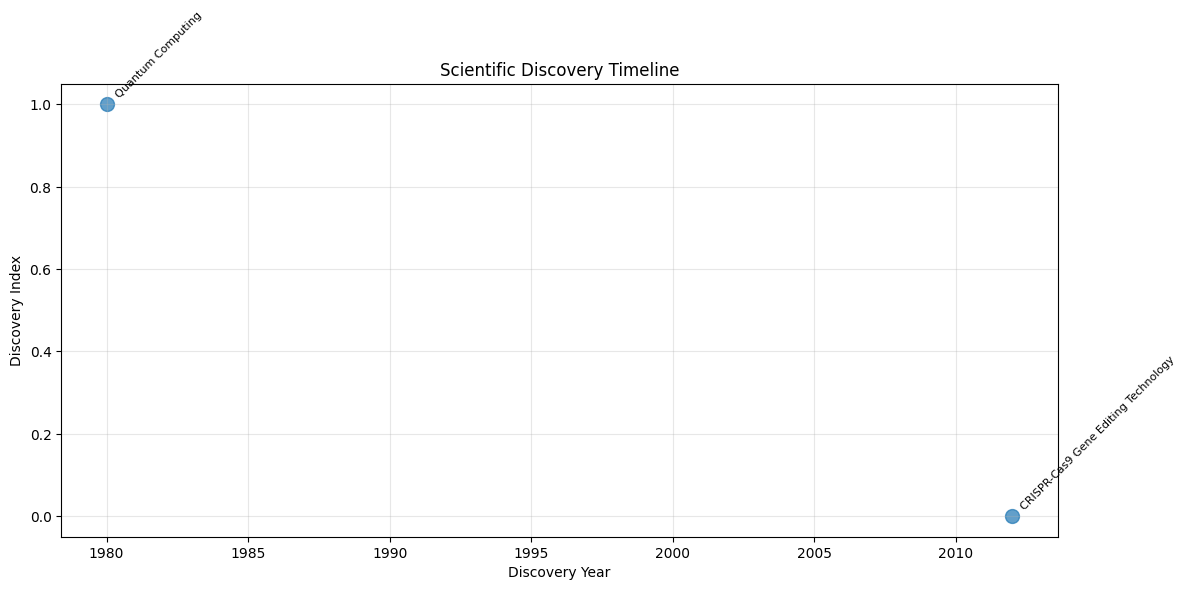

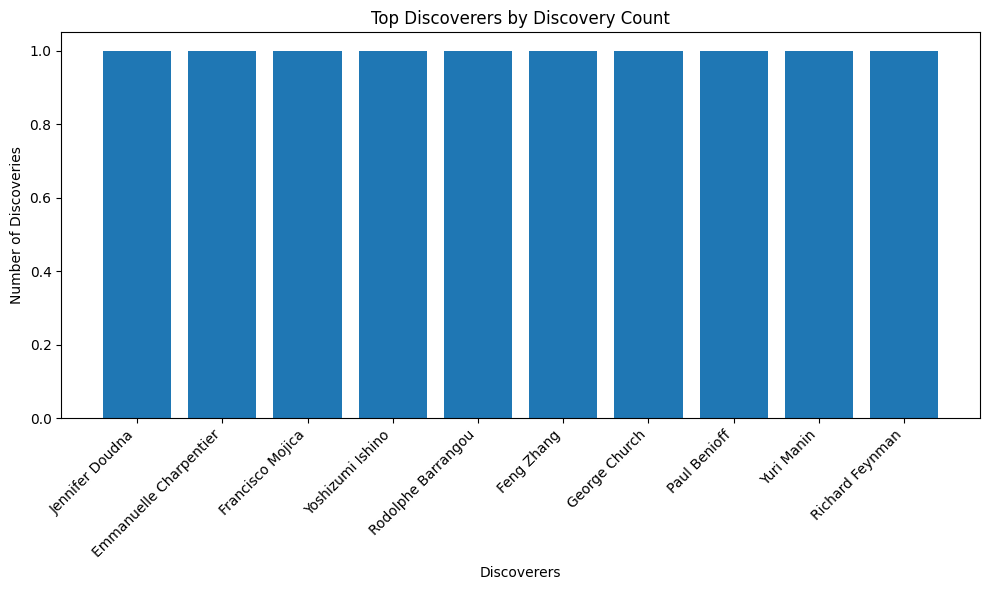

✅ Visualization demo completed

✅ Full demo completed! (All data processed in memory)

🎉 System execution completed successfully!


In [78]:
main()